# 0.0 IMPORTS

In [68]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import Image, display

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 0.1 Loadind Data

In [3]:
# Dados de treinamento
df_training_feature = pd.read_csv( '../data/training_set_features.csv', low_memory=False)
df_training_labels = pd.read_csv( '../data/training_set_labels.csv', low_memory=False)

# Dados de teste
df_submission = pd.read_csv( '../data/submission_format.csv', low_memory=False)
df_test = pd.read_csv( '../data/test_set_features.csv', low_memory=False)

# Juntando as informações dos dados de treinamento
df_raw = pd.merge(df_training_feature, df_training_labels, how='left', on='respondent_id')

In [4]:
df_raw.head(5)

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                    1.0               0.0                   0.0   
1                    1.0               0.0                   0.0   
2                    0.0               NaN                   NaN   
3                    0.0               0.0                   1.0   
4                    1.0               0.0                   0.0   

   chronic_med_condition  child_under_6_months  health_worker  \
0                    0.0                   0.0            0.0   
1                    0.0                   0.0            0.0   
2                    1.0                   0.0            0.0   
3                    1.0                   0.0            0.0   
4                    0.0                   0.0            0.0   

   health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
0               1.0                          3.0                1.0   
1               1.0                          5.0                4.0   
2               NaN                          3.0                1.0   
3               NaN                          3.0                3.0   
4               NaN                          3.0                3.0   

   opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
0                          2.0                          2.0   
1                          4.0                          4.0   
2                          1.0                          4.0   
3                          5.0                          5.0   
4                          2.0                          3.0   

   opinion_seas_risk  opinion_seas_sick_from_vacc      age_group  \
0                1.0                          2.0  55 - 64 Years   
1                2.0                          4.0  35 - 44 Years   
2                1.0                          2.0  18 - 34 Years   
3                4.0                          1.0      65+ Years   
4                1.0                          4.0  45 - 54 Years   

          education   race     sex             income_poverty marital_status  \
0        < 12 Years  White  Female              Below Poverty    Not Married   
1          12 Years  White    Male              Below Poverty    Not Married   
2  College Graduate  White    Male  <= $75,000, Above Poverty    Not Married   
3          12 Years  White  Female              Below Poverty    Not Married   
4      Some College  White  Female  <= $75,000, Above Poverty        Married   

  rent_or_own   employment_status hhs_geo_region                census_msa  \
0         Own  Not in Labor Force       oxchjgsf                   Non-MSA   
1        Rent            Employed       bhuqouqj  MSA, Not Principle  City   
2         Own         

# 1.0. Passo 1 - DESCRIÇÃO DOS DADOS

## 1.1. Data Dimensions

In [5]:
df1 = df_raw.copy()

In [6]:
print(f'Numero de Linhas: {df1.shape[0]}')
print(f'Numero de Colunas: {df1.shape[1]}')

Numero de Linhas: 26707
Numero de Colunas: 38


## 1.2. Data Types

In [7]:
df1.dtypes.to_frame(name='dtype')

dtype
respondent_id                  int64
h1n1_concern                 float64
h1n1_knowledge               float64
behavioral_antiviral_meds    float64
behavioral_avoidance         float64
behavioral_face_mask         float64
behavioral_wash_hands        float64
behavioral_large_gatherings  float64
behavioral_outside_home      float64
behavioral_touch_face        float64
doctor_recc_h1n1             float64
doctor_recc_seasonal         float64
chronic_med_condition        float64
child_under_6_months         float64
health_worker                float64
health_insurance             float64
opinion_h1n1_vacc_effective  float64
opinion_h1n1_risk            float64
opinion_h1n1_sick_from_vacc  float64
opinion_seas_vacc_effective  float64
opinion_seas_risk            float64
opinion_seas_sick_from_vacc  float64
age_group                     object
education                     object
race                          object
sex                           object
income_poverty                object
marital_status                object
rent_or_own                   object
employment_status             object
hhs_geo_region                object
census_msa                    object
household_adults             float64
household_children           float64
employment_industry           object
employment_occupation         object
h1n1_vaccine                   int64
seasonal_vaccine               int64

## 1.3. Check NA

In [8]:
df1.isna().sum().to_frame(name='dtype')

dtype
respondent_id                    0
h1n1_concern                    92
h1n1_knowledge                 116
behavioral_antiviral_meds       71
behavioral_avoidance           208
behavioral_face_mask            19
behavioral_wash_hands           42
behavioral_large_gatherings     87
behavioral_outside_home         82
behavioral_touch_face          128
doctor_recc_h1n1              2160
doctor_recc_seasonal          2160
chronic_med_condition          971
child_under_6_months           820
health_worker                  804
health_insurance             12274
opinion_h1n1_vacc_effective    391
opinion_h1n1_risk              388
opinion_h1n1_sick_from_vacc    395
opinion_seas_vacc_effective    462
opinion_seas_risk              514
opinion_seas_sick_from_vacc    537
age_group                        0
education                     1407
race                             0
sex                              0
income_poverty                4423
marital_status                1408
rent_or_own                   2042
employment_status             1463
hhs_geo_region                   0
census_msa                       0
household_adults               249
household_children             249
employment_industry          13330
employment_occupation        13470
h1n1_vaccine                     0
seasonal_vaccine                 0

## 1.4. Fillout NA

In [9]:
df1['employment_occupation'].value_counts(dropna=False, normalize=True)

employment_occupation
NaN         0.504362
xtkaffoo    0.066574
mxkfnird    0.056502
emcorrxb    0.047553
cmhcxjea    0.046692
xgwztkwe    0.040514
hfxkjkmi    0.028682
qxajmpny    0.020519
xqwwgdyp    0.018160
kldqjyjy    0.017561
uqqtjvyb    0.016924
tfqavkke    0.014528
ukymxvdu    0.013929
vlluhbov    0.013255
oijqvulv    0.012881
ccgxvspp    0.012768
bxpfxfdn    0.012394
haliazsg    0.011083
rcertsgn    0.010334
xzmlyyjv    0.009286
dlvbwzss    0.008500
hodpvpew    0.007788
dcjcmpih    0.005542
pvmttkik    0.003669
Name: proportion, dtype: float64

In [10]:
# Variáveis de percepção/opinião --Preenchido com a mediana
df1['h1n1_concern'] = df1['h1n1_concern'].apply( lambda x: 2 if math.isnan( x ) else x )
df1['h1n1_knowledge'] = df1['h1n1_knowledge'].apply( lambda x: 1 if math.isnan( x ) else x )
df1['opinion_h1n1_vacc_effective'] = df1['opinion_h1n1_vacc_effective'].apply( lambda x: 4 if math.isnan( x ) else x )
df1['opinion_h1n1_risk'] = df1['opinion_h1n1_risk'].apply( lambda x: 2 if math.isnan( x ) else x )
df1['opinion_h1n1_sick_from_vacc'] = df1['opinion_h1n1_sick_from_vacc'].apply( lambda x: 2 if math.isnan( x ) else x )
df1['opinion_seas_vacc_effective'] = df1['opinion_seas_vacc_effective'].apply( lambda x: 4 if math.isnan( x ) else x )
df1['opinion_seas_risk'] = df1['opinion_seas_risk'].apply( lambda x: 2 if math.isnan( x ) else x )
df1['opinion_seas_sick_from_vacc'] = df1['opinion_seas_sick_from_vacc'].apply( lambda x: 2 if math.isnan( x ) else x )

# Variáveis comportamentais -- Preenchido com 0 assumindo que o comportamento não foi realizado
df1['behavioral_antiviral_meds'] = df1['behavioral_antiviral_meds'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_avoidance'] = df1['behavioral_avoidance'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_face_mask'] = df1['behavioral_face_mask'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_wash_hands'] = df1['behavioral_wash_hands'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_large_gatherings'] = df1['behavioral_large_gatherings'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_outside_home'] = df1['behavioral_outside_home'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['behavioral_touch_face'] = df1['behavioral_touch_face'].apply( lambda x: 0 if math.isnan( x ) else x )

# Variáveis de saúde -- Preenchido com a moda
df1['doctor_recc_h1n1'] = df1['doctor_recc_h1n1'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['doctor_recc_seasonal'] = df1['doctor_recc_seasonal'].apply( lambda x: 0 if math.isnan( x ) else x ) 
df1['chronic_med_condition'] = df1['chronic_med_condition'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['child_under_6_months'] = df1['child_under_6_months'].apply( lambda x: 0 if math.isnan( x ) else x )
df1['health_worker'] = df1['health_worker'].apply( lambda x: 0 if math.isnan( x ) else x ) 
df1['health_insurance'] = df1['health_insurance'].apply( lambda x: -1 if math.isnan( x ) else x ) # Criado uma nova categoria para os casos "desconhecido"

# Variáveis Demográficas -- Preenchido com a moda
df1['education'] = df1['education'].apply( lambda x: 'College Graduate' if pd.isna( x ) else x )
df1['income_poverty'] = df1['income_poverty'].apply( lambda x: '<= $75,000, Above Poverty' if pd.isna( x ) else x )
df1['marital_status'] = df1['marital_status'].apply( lambda x: 'Married' if pd.isna( x ) else x )
df1['rent_or_own'] = df1['rent_or_own'].apply( lambda x: 'Own' if pd.isna( x ) else x )
df1['employment_status'] = df1['employment_status'].apply( lambda x: 'Employed' if pd.isna( x ) else x )

# Domicílio -- Preenchido com a mediana
df1['household_adults'] = df1['household_adults'].apply( lambda x: 1 if math.isnan( x ) else x )
df1['household_children'] = df1['household_children'].apply( lambda x: 0 if math.isnan( x ) else x )



In [11]:
df1.isna().sum().to_frame(name='dtype')

dtype
respondent_id                    0
h1n1_concern                     0
h1n1_knowledge                   0
behavioral_antiviral_meds        0
behavioral_avoidance             0
behavioral_face_mask             0
behavioral_wash_hands            0
behavioral_large_gatherings      0
behavioral_outside_home          0
behavioral_touch_face            0
doctor_recc_h1n1                 0
doctor_recc_seasonal             0
chronic_med_condition            0
child_under_6_months             0
health_worker                    0
health_insurance                 0
opinion_h1n1_vacc_effective      0
opinion_h1n1_risk                0
opinion_h1n1_sick_from_vacc      0
opinion_seas_vacc_effective      0
opinion_seas_risk                0
opinion_seas_sick_from_vacc      0
age_group                        0
education                        0
race                             0
sex                              0
income_poverty                   0
marital_status                   0
rent_or_own                      0
employment_status                0
hhs_geo_region                   0
census_msa                       0
household_adults                 0
household_children               0
employment_industry          13330
employment_occupation        13470
h1n1_vaccine                     0
seasonal_vaccine                 0

## 1.5. Change Types

In [12]:
df1.dtypes.to_frame(name='dtype')

dtype
respondent_id                  int64
h1n1_concern                 float64
h1n1_knowledge               float64
behavioral_antiviral_meds    float64
behavioral_avoidance         float64
behavioral_face_mask         float64
behavioral_wash_hands        float64
behavioral_large_gatherings  float64
behavioral_outside_home      float64
behavioral_touch_face        float64
doctor_recc_h1n1             float64
doctor_recc_seasonal         float64
chronic_med_condition        float64
child_under_6_months         float64
health_worker                float64
health_insurance             float64
opinion_h1n1_vacc_effective  float64
opinion_h1n1_risk            float64
opinion_h1n1_sick_from_vacc  float64
opinion_seas_vacc_effective  float64
opinion_seas_risk            float64
opinion_seas_sick_from_vacc  float64
age_group                     object
education                     object
race                          object
sex                           object
income_poverty                object
marital_status                object
rent_or_own                   object
employment_status             object
hhs_geo_region                object
census_msa                    object
household_adults             float64
household_children           float64
employment_industry           object
employment_occupation         object
h1n1_vaccine                   int64
seasonal_vaccine               int64

In [13]:
# Variáveis de percepção/opinião
df1['h1n1_concern'] = df1['h1n1_concern'].astype( int )
df1['h1n1_knowledge'] = df1['h1n1_knowledge'].astype( int )
df1['opinion_h1n1_vacc_effective'] = df1['opinion_h1n1_vacc_effective'].astype( int )
df1['opinion_h1n1_risk'] = df1['opinion_h1n1_risk'].astype( int )
df1['opinion_h1n1_sick_from_vacc'] = df1['opinion_h1n1_sick_from_vacc'].astype( int )
df1['opinion_seas_vacc_effective'] = df1['opinion_seas_vacc_effective'].astype( int )
df1['opinion_seas_risk'] = df1['opinion_seas_risk'].astype( int )
df1['opinion_seas_sick_from_vacc'] = df1['opinion_seas_sick_from_vacc'].astype( int )

# Variáveis comportamentais
df1['behavioral_antiviral_meds'] = df1['behavioral_antiviral_meds'].astype( int )
df1['behavioral_avoidance'] = df1['behavioral_avoidance'].astype( int )
df1['behavioral_face_mask'] = df1['behavioral_face_mask'].astype( int )
df1['behavioral_wash_hands'] = df1['behavioral_wash_hands'].astype( int )
df1['behavioral_large_gatherings'] = df1['behavioral_large_gatherings'].astype( int )
df1['behavioral_outside_home'] = df1['behavioral_outside_home'].astype( int )
df1['behavioral_touch_face'] = df1['behavioral_touch_face'].astype( int )

# Variáveis de saúde -- Preenchido com a moda
df1['doctor_recc_h1n1'] = df1['doctor_recc_h1n1'].astype( int )
df1['doctor_recc_seasonal'] = df1['doctor_recc_seasonal'].astype( int ) 
df1['chronic_med_condition'] = df1['chronic_med_condition'].astype( int )
df1['child_under_6_months'] = df1['child_under_6_months'].astype( int )
df1['health_worker'] = df1['health_worker'].astype( int ) 
df1['health_insurance'] = df1['health_insurance'].astype( int )

# Domicílio -- Preenchido com a mediana
df1['household_adults'] = df1['household_adults'].astype( int )
df1['household_children'] = df1['household_children'].astype( int )

In [14]:
df1.dtypes.to_frame(name='dtype')

dtype
respondent_id                 int64
h1n1_concern                  int64
h1n1_knowledge                int64
behavioral_antiviral_meds     int64
behavioral_avoidance          int64
behavioral_face_mask          int64
behavioral_wash_hands         int64
behavioral_large_gatherings   int64
behavioral_outside_home       int64
behavioral_touch_face         int64
doctor_recc_h1n1              int64
doctor_recc_seasonal          int64
chronic_med_condition         int64
child_under_6_months          int64
health_worker                 int64
health_insurance              int64
opinion_h1n1_vacc_effective   int64
opinion_h1n1_risk             int64
opinion_h1n1_sick_from_vacc   int64
opinion_seas_vacc_effective   int64
opinion_seas_risk             int64
opinion_seas_sick_from_vacc   int64
age_group                    object
education                    object
race                         object
sex                          object
income_poverty               object
marital_status               object
rent_or_own                  object
employment_status            object
hhs_geo_region               object
census_msa                   object
household_adults              int64
household_children            int64
employment_industry          object
employment_occupation        object
h1n1_vaccine                  int64
seasonal_vaccine              int64

## 1.6. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1. Numerical Attributes

In [16]:
df1.describe()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
count   26707.000000  26707.000000    26707.000000               26707.000000   
mean    13353.000000      1.619800        1.261392                   0.048714   
std      7709.791156      0.909016        0.617047                   0.215273   
min         0.000000      0.000000        0.000000                   0.000000   
25%      6676.500000      1.000000        1.000000                   0.000000   
50%     13353.000000      2.000000        1.000000                   0.000000   
75%     20029.500000      2.000000        2.000000                   0.000000   
max     26706.000000      3.000000        2.000000                   1.000000   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
count          26707.000000          26707.000000           26707.000000   
mean               0.719961              0.068933               0.824316   
std                0.449026              0.253345               0.380558   
min                0.000000              0.000000               0.000000   
25%                0.000000              0.000000               1.000000   
50%                1.000000              0.000000               1.000000   
75%                1.000000              0.000000               1.000000   
max                1.000000              1.000000               1.000000   

       behavioral_large_gatherings  behavioral_outside_home  \
count                 26707.000000             26707.000000   
mean                      0.357472                 0.336279   
std                       0.479264                 0.472444   
min                       0.000000                 0.000000   
25%                       0.000000                 0.000000   
50%                       0.000000                 0.000000   
75%                       1.000000                 1.000000   
max                       1.000000                 1.000000   

       behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
count           26707.000000      26707.000000          26707.000000   
mean                0.674018          0.202494              0.303067   
std                 0.468749          0.401866              0.459592   
min                 0.000000          0.000000              0.000000   
25%                 0.000000          0.000000              0.000000   
50%                 1.000000          0.000000              0.000000   
75%                 1.000000          0.000000              1.000000   
max                 1.000000          1.000000              1.000000   

       chronic_med_condition  child_under_6_months  health_worker  \
count           26707.000000          26707.000000   26707.000000   
mean                0.272962              0.080054       0.108548   
std                 0.445490              0.271382       0.311077   
min                 0.000000              0.000000       0.000000   
25%                 0.000000              0.000000       0.000000   
50%                 0.000000              0.000000       0.000000   
75%                 1.000000              0.000000       0.000000   
max                 1.000000              1.000000       1.000000   

       health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
count      26707.000000                 26707.000000       26707.000000   
mean           0.015839                     3.852810           2.337589   
std            0.966841                     1.000195           1.276825   
min           -1.000000                     1.000000           1.000000   
25%           -1.000000                     3.000000           1.000000   
50%            0.000000                     4.000000           2.000000   
75%            1.000000                     5.000000           4.000000   
max            1.000000                     5.000000           5.000000   

       opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
count     

### 1.6.2. Categorical Attributes

In [17]:
df1.describe(include=['object'])

age_group         education   race     sex             income_poverty  \
count       26707             26707  26707   26707                      26707   
unique          5                 4      4       2                          3   
top     65+ Years  College Graduate  White  Female  <= $75,000, Above Poverty   
freq         6843             11504  21222   15858                      17200   

       marital_status rent_or_own employment_status hhs_geo_region  \
count           26707       26707             26707          26707   
unique              2           2                 3             10   
top           Married         Own          Employed       lzgpxyit   
freq            14963       20778             15023           4297   

                      census_msa employment_industry employment_occupation  
count                      26707               13377                 13237  
unique                         3                  21                    23  
top     MSA, Not Principle  City            fcxhlnwr              xtkaffoo  
freq                       11645                2468                  1778

In [18]:
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

age_group                 5
education                 4
race                      4
sex                       2
income_poverty            3
marital_status            2
rent_or_own               2
employment_status         3
hhs_geo_region           10
census_msa                3
employment_industry      22
employment_occupation    24
dtype: int64

# 2.0. FEATURA ENGENEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

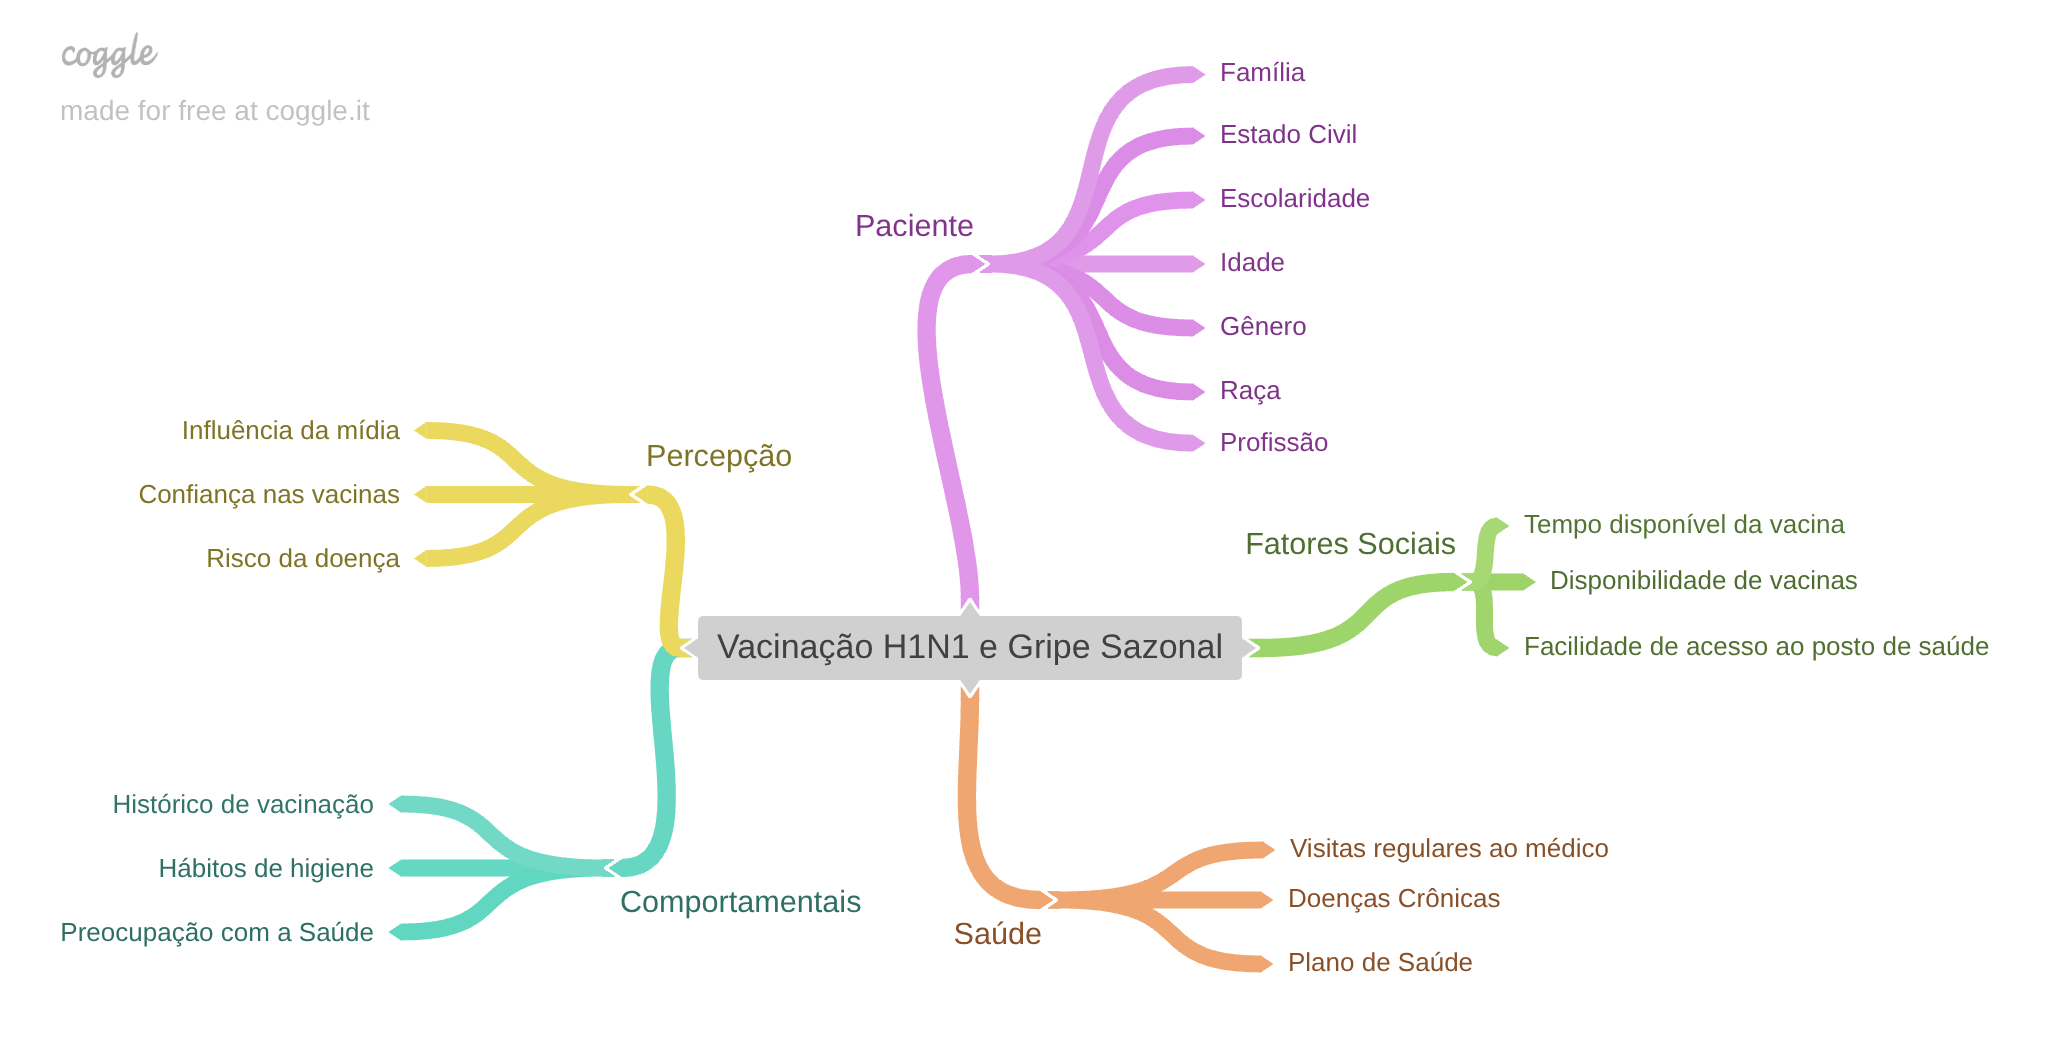

In [21]:
display(Image( filename='../img/mapa_mental.png'))

## 2.2. Criação das Hipóteses

### 2.2.1 Hipóteses Paciente

1. Pessoas mais velhas têm maior taxa de vacinação por maior risco percebido.
2. Pacientes com maior escolaridade são mais propensos a se vacinar.
3. Pessoas casadas tendem a se vacinar mais.
4. Mulheres se vacinam mais do que homens.
5. Pacientes com renda mais alta se vacina mais do que pacientes com renda mais baixa.
6. Pessoas não brancas apresentam menor taxa de vacinação.
7. Pacientes com filhos pequenos tem maior probabilidade de vacinação para proteger a família.
8. Moradores de áreas urbanas vacinam-se mais do que os de áreas rurais.

### 2.2.2 Hipóteses Percepções e Comportamento de Saúde

1. Pessoas que percebem alto risco de contágio vacinam-se mais.
2. Indivíduos que confiam no sistema de saúde têm maior taxa de vacinação.
3. Pessoas com histórico de doenças respiratórias buscam mais a vacina.
4. Quem recebeu vacina em anos anteriores tende a repetir o comportamento.
5. Indivíduos que frequentam consultas médicas regularmente vacinam-se mais.
6. Quem tem medo de efeitos colaterais evita a vacinação.
7. O nível de conhecimento sobre a gripe H1N1 está diretamente relacionado à probabilidade de vacinação.
8. Indivíduos com amigos ou familiares vacinados tendem a seguir o mesmo comportamento.

### 2.2.3 Hipóteses Situação de Trabalho e Acesso

1. Pessoas empregadas formalmente têm mais acesso a campanhas corporativas de vacinação.
2. Indivíduos com seguro saúde vacinam-se mais facilmente.
3. Pessoas que possuem moradia própria tendem a apresentar maior estabilidade e maior adesão vacinal.
4. A proximidade de locais de vacinação aumenta a probabilidade de imunização.
5. Profissionais da área de saúde são mais vacinados por exigência profissional.
6. Pessoas que trabalham remotamente podem sentir menor urgência de se vacinar.

### 2.2.4 Hipóteses Influências Sociais e Culturais

1. Influência familiar aumenta a probabilidade de vacinação.
2. A pressão social pode motivar indivíduos a se vacinarem para “não ficar de fora”.
3. Em comunidades com alta taxa de vacinação, o comportamento tende a se repetir.
4. Amigos vacinados servem como exemplo e estímulo.
5. Estigma ou desinformação cultural pode diminuir a adesão.
6. Campanhas públicas locais influenciam positivamente a decisão.
7. Experiências negativas com vacinas anteriores reduzem a confiança.

## 2.3. Feature Engineering

In [22]:
# nível de prevenção geral
df2['health_behaviors_score'] = df2['behavioral_antiviral_meds'] + df2['behavioral_avoidance'] + df2['behavioral_face_mask'] + df2['behavioral_wash_hands'] + df2['behavioral_large_gatherings'] + df2['behavioral_outside_home'] + df2['behavioral_touch_face']

# recomendação médica para qualquer vacina
df2['doctor_recc_any'] = ( (df2['doctor_recc_h1n1'] == 1 ) | (df2['doctor_recc_seasonal'] == 1 )).astype(int)

# score de confiança nas vacinas
cols_opinion = [
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

cols_neg = ['opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc']

for col in cols_neg:
    df2[col] = 6 - df2[col] # inverte o sentido

df2['opinion_vacc_positive'] = df2[cols_opinion].mean(axis=1)

# Percepção de risco
cols_risk = ['opinion_h1n1_risk', 'opinion_seas_risk']
df2['risk_awareness_score'] = df2[cols_risk].mean(axis=1)

# crianças no domicílio
df2['has_children'] = (df2['household_children'] > 0).astype(int)

# tamanho da familia
df2['family_size'] = df2['household_children'] + df2['household_adults']

# Casado com filhos
df2['is_married_parent'] = ((df2['marital_status'] == 'Married') & (df2['has_children'] == 1)).astype(int)

# education
education_map = {
    '< 12 Years': 0,
    '12 Years': 1,
    'Some College': 2,
    'College Graduate': 3
}

df2['education_level_num'] = df2['education'].map(education_map)

# income_poverty
income_map = {
    'Below Poverty': 0, 
    '<= $75,000, Above Poverty': 1,
    '> $75,000': 2
}

df2['income_category'] = df2['income_poverty'].map(income_map)

# Possui seguro saúde ou recomendação medica
df2['has_health_access'] = ( (df2['health_insurance'] == 1) | (df2['doctor_recc_any'] == 1) ).astype(int)

# Grupo de risco
df2['chronic_risk_group'] = ( (df2['chronic_med_condition'] == 1) | (df2['child_under_6_months'] == 1) ).astype(int)

# Eficácia Vacina X Risco percebido
df2['opinion_gap'] = df2['opinion_h1n1_vacc_effective'] - df2['opinion_h1n1_risk']

# Crença na eficácia da vacina
df2['trust_in_vaccines'] = ( df2['opinion_h1n1_vacc_effective'] > df2['opinion_h1n1_sick_from_vacc']).astype(int)

In [23]:
df2[['health_behaviors_score', 'doctor_recc_any', 'opinion_vacc_positive', 'risk_awareness_score',
    'has_children', 'family_size', 'is_married_parent', 'education_level_num', 'income_category', 'has_health_access', 
    'chronic_risk_group', 'opinion_gap', 'trust_in_vaccines']].sample(5).T

23550     14037     3899   19925     2034 
health_behaviors_score  3.000000  2.000000  4.000000    2.0  0.000000
doctor_recc_any         0.000000  0.000000  0.000000    0.0  0.000000
opinion_vacc_positive   3.333333  4.166667  3.333333    3.5  2.333333
risk_awareness_score    4.000000  4.000000  2.000000    3.0  1.500000
has_children            0.000000  0.000000  0.000000    0.0  0.000000
family_size             0.000000  1.000000  1.000000    2.0  1.000000
is_married_parent       0.000000  0.000000  0.000000    0.0  0.000000
education_level_num     2.000000  2.000000  1.000000    1.0  2.000000
income_category         1.000000  2.000000  2.000000    1.0  2.000000
has_health_access       0.000000  0.000000  0.000000    0.0  0.000000
chronic_risk_group      1.000000  0.000000  0.000000    0.0  0.000000
opinion_gap             0.000000  0.000000  1.000000    2.0 -1.000000
trust_in_vaccines       1.000000  0.000000  0.000000    0.0  0.000000

# 3.0 FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0             1               0                          0   
1              1             3               2                          0   
2              2             1               1                          0   
3              3             1               1                          0   
4              4             2               1                          0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                     0                     0                      0   
1                     1                     0                      1   
2                     1                     0                      0   
3                     1                     0                      1   
4                     1                     0                      1   

   behavioral_large_gatherings  behavioral_outside_home  \
0                            0                        1   
1                            0                        1   
2                            0                        0   
3                            1                        0   
4                            1                        0   

   behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                      1                 0                     0   
1                      1                 0                     0   
2                      0                 0                     0   
3                      0                 0                     1   
4                      1                 0                     0   

   chronic_med_condition  child_under_6_months  health_worker  \
0                      0                     0              0   
1                      0                     0              0   
2                      1                     0              0   
3                      1                     0              0   
4                      0                     0              0   

   health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
0                 1                            3                  1   
1                 1                            5                  4   
2                -1                            3                  1   
3                -1                            3                  3   
4                -1                            3                  3   

   opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
0                            4                            2   
1                            2                            4   
2                            5                            4   
3                            1                            5   
4                            4                            3   

   opinion_seas_risk  opinion_seas_sick_from_vacc      age_group  \
0                  1                            4  55 - 64 Years   
1                  2                            2  35 - 44 Years   
2                  1                            4  18 - 34 Years   
3                  4                            5      65+ Years   
4                  1                            2  45 - 54 Years   

          education   race     sex             income_poverty marital_status  \
0        < 12 Years  White  Female              Below Poverty    Not Married   
1          12 Years  White    Male              Below Poverty    Not Married   
2  College Graduate  White    Male  <= $75,000, Above Poverty    Not Married   
3          12 Years  White  Female              Below Poverty    Not Married   
4      Some College  White  Female  <= $75,000, Above Poverty        Married   

  rent_or_own   employment_status hhs_geo_region                census_msa  \
0         Own  Not in Labor Force       oxchjgsf                   Non-MSA   
1        Rent            Employed       bhuqouqj  MSA, Not Principle  City   
2         Own         

## 3.1. Seleção das colunas

In [26]:
cols_drop = ['respondent_id', 'education', 'income_poverty', 'employment_status', 'hhs_geo_region', 'census_msa',
             'employment_industry', 'employment_occupation']

df3 = df3.drop( cols_drop, axis=1 )

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [27]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

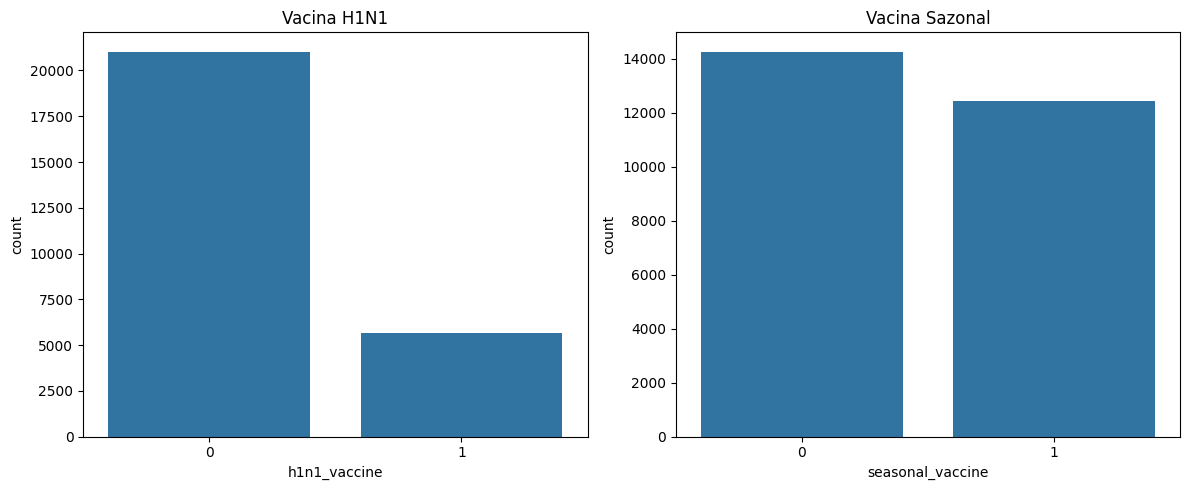

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='h1n1_vaccine', data=df4)
plt.title('Vacina H1N1')

plt.subplot(1, 2, 2)
sns.countplot(x='seasonal_vaccine', data=df4)
plt.title('Vacina Sazonal')

plt.tight_layout()
plt.show()

### 4.1.2. Numerical Variable

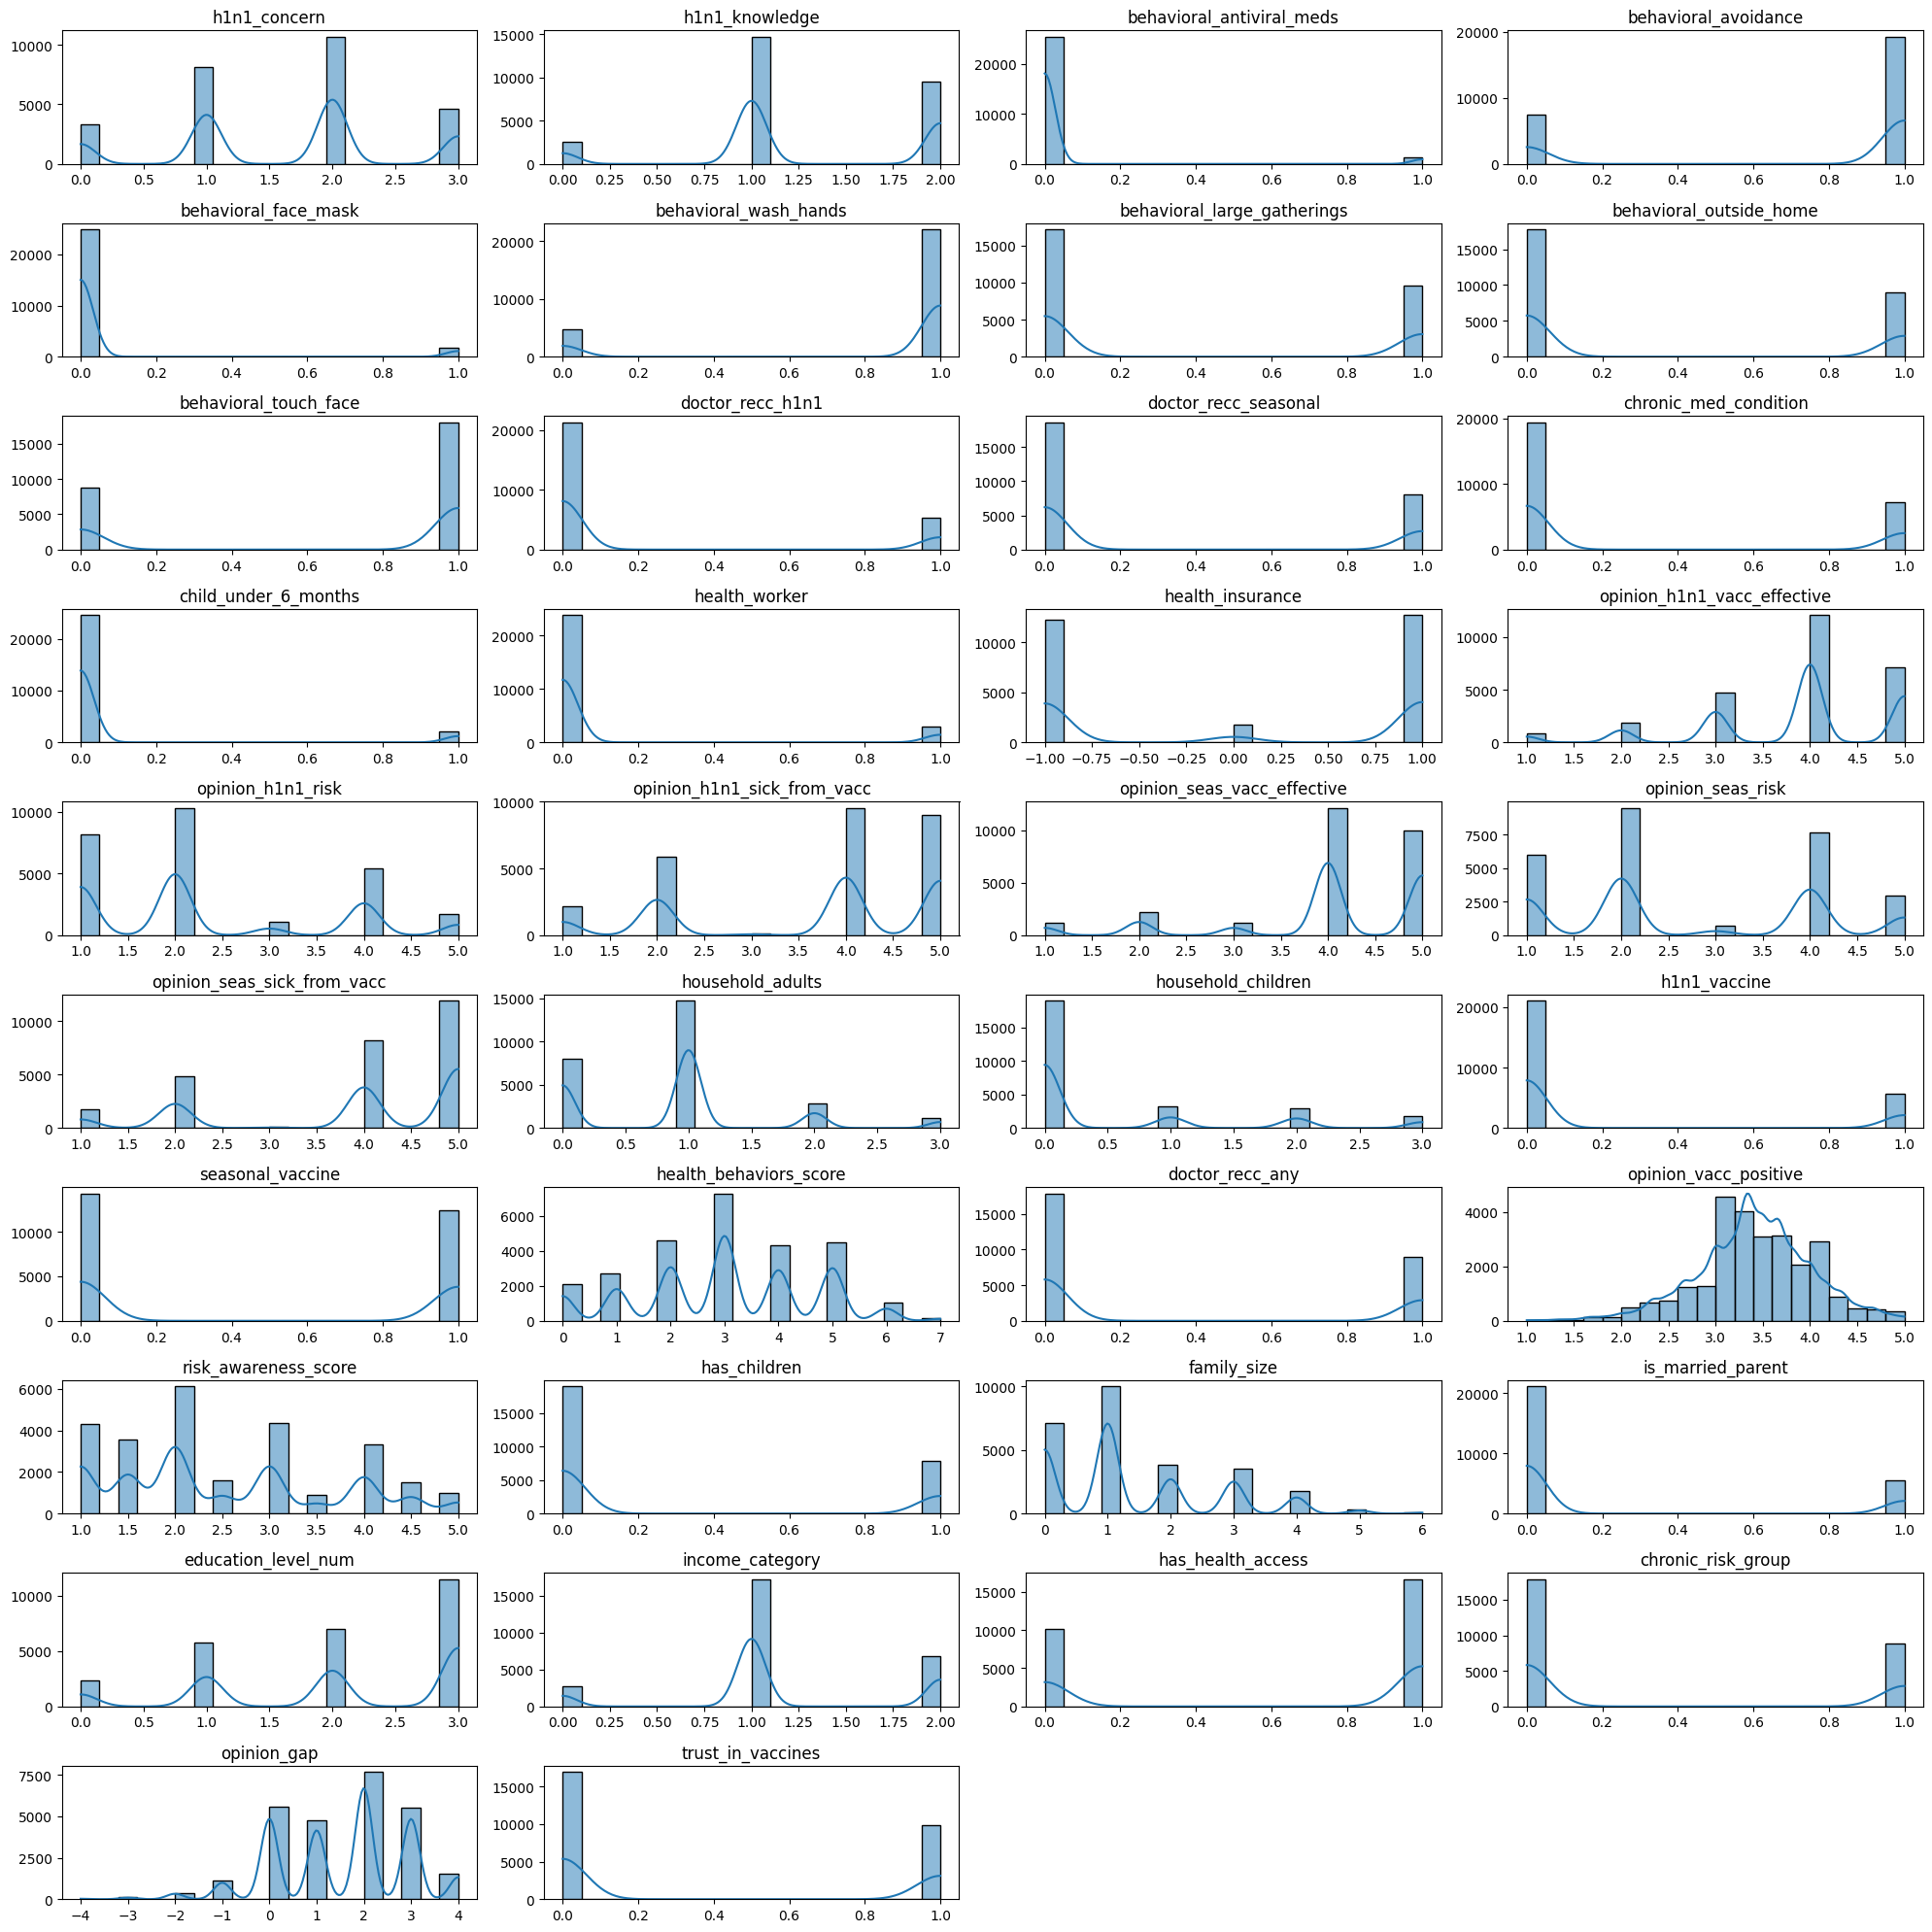

In [29]:
# Seleciona apenas as variáveis numéricas
numeric_cols = df4.select_dtypes(include=['int64', 'float64']).columns

# Define o tamanho da grade de subplots
n_cols = 4
n_rows = int(len(numeric_cols) / n_cols) + 1

plt.figure(figsize=(20, 20))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df4[col], kde=True, bins=20)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### 4.1.3. Categorical Variable

In [30]:
cat_cols = df4.select_dtypes(include=['object']).columns
cat_cols

Index(['age_group', 'race', 'sex', 'marital_status', 'rent_or_own'], dtype='object')

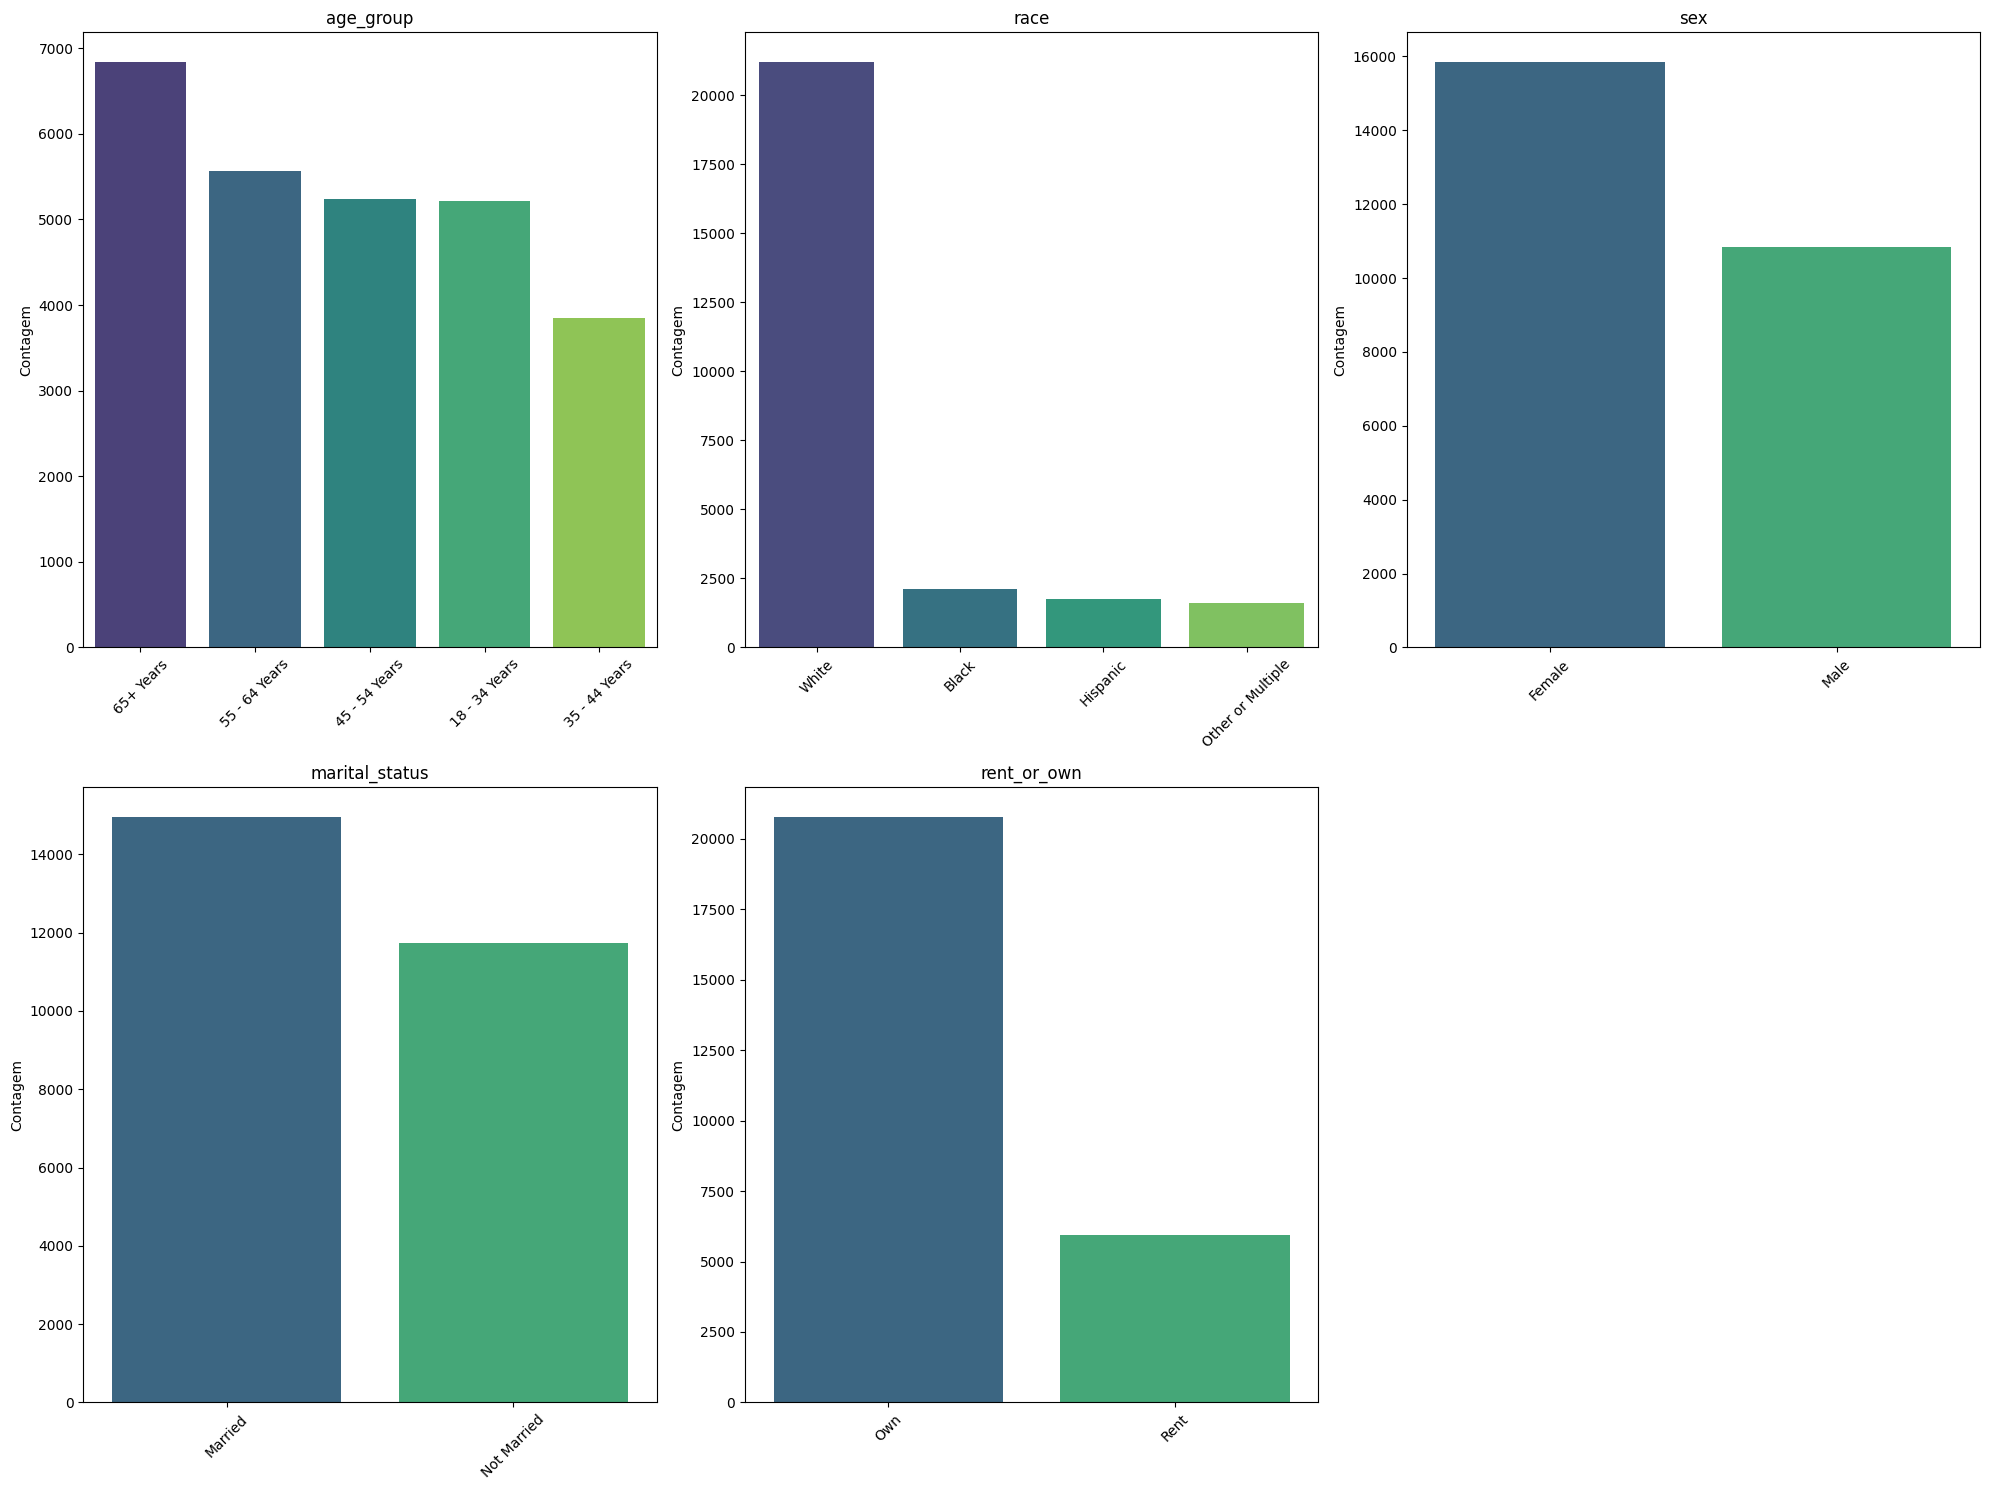

In [31]:
n_cols = 3
n_rows = int(len(cat_cols) / n_cols) + 1

plt.figure(figsize=(20, 15))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    order = df4[col].value_counts().index
    sns.countplot(data=df4, x=col, order=order, palette='viridis')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Contagem')

plt.tight_layout()
plt.show()


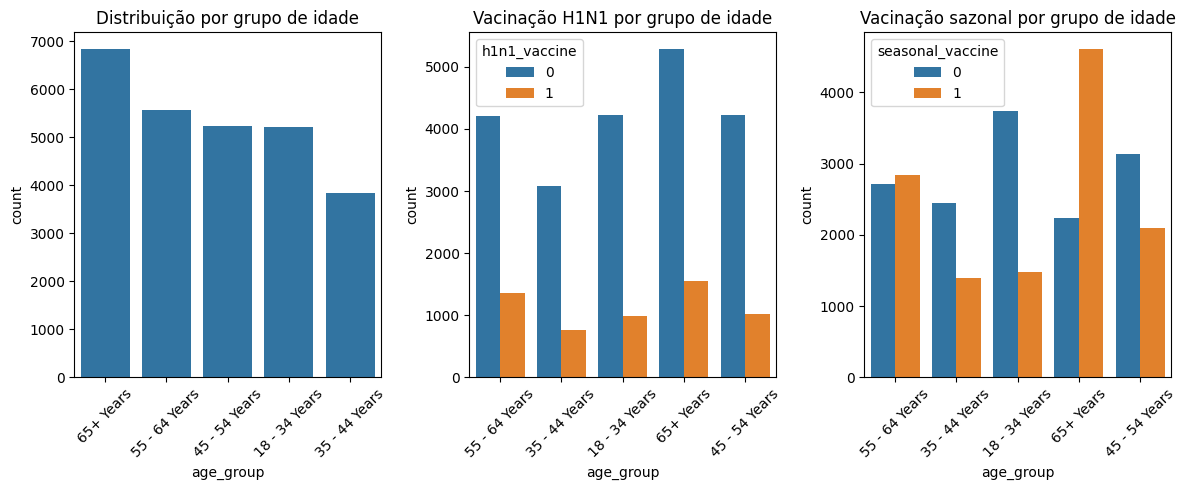

In [32]:
# age_group
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='age_group', order=df1['age_group'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição por grupo de idade')


plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='age_group', hue='h1n1_vaccine')
plt.xticks(rotation=45)
plt.title('Vacinação H1N1 por grupo de idade')

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='age_group', hue='seasonal_vaccine')
plt.xticks(rotation=45)
plt.title('Vacinação sazonal por grupo de idade')

plt.tight_layout()
plt.show()

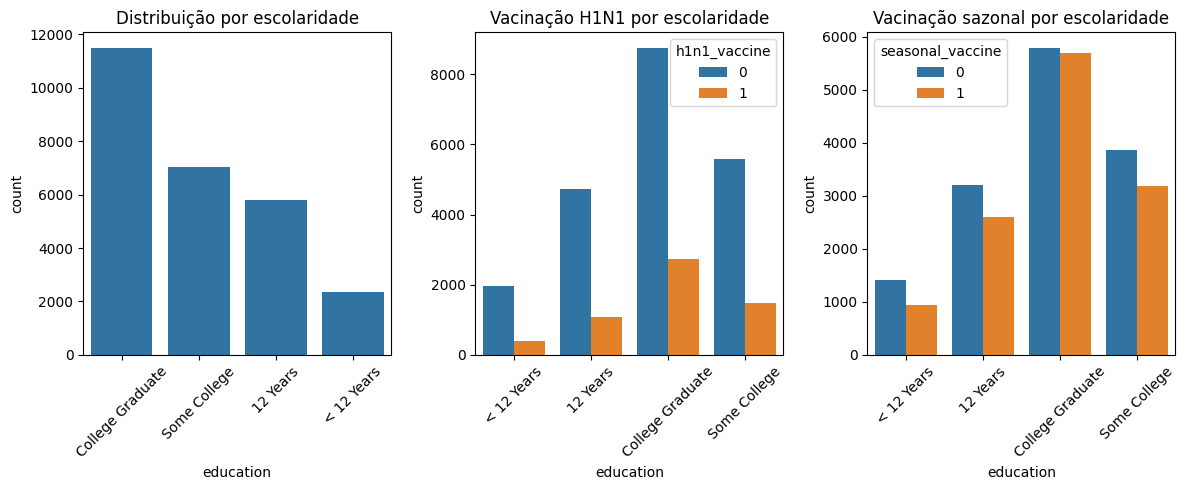

In [33]:
# education
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='education', order=df1['education'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição por escolaridade')


plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='education', hue='h1n1_vaccine')
plt.xticks(rotation=45)
plt.title('Vacinação H1N1 por escolaridade')

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='education', hue='seasonal_vaccine')
plt.xticks(rotation=45)
plt.title('Vacinação sazonal por escolaridade')

plt.tight_layout()
plt.show()

## 4.2. Analise Bivariada

**H1 - Pessoas mais velhas têm maior taxa de vacinação por maior risco percebido.**

**VERDADEIRA** - Pessoas mais velhas se vacinam mais

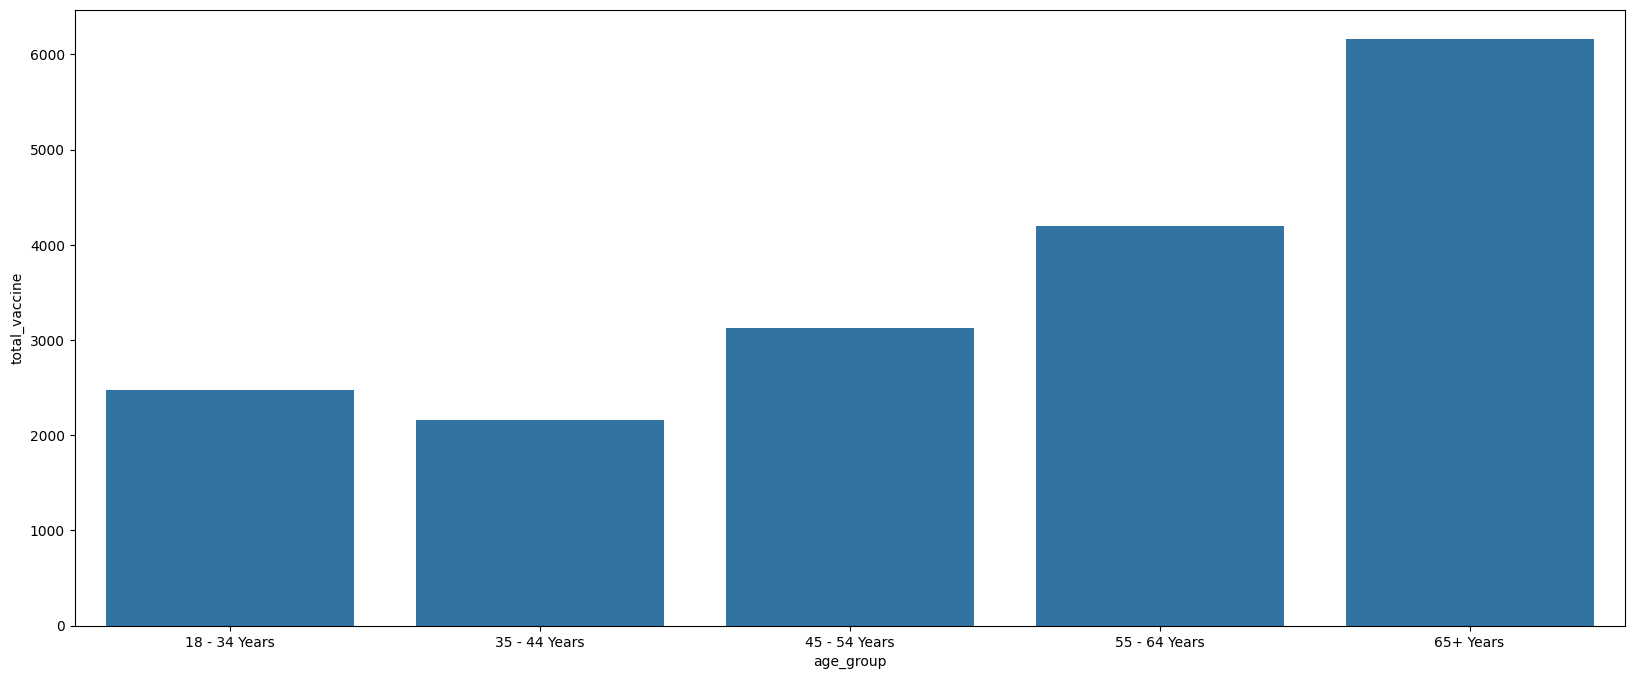

In [34]:
aux1 = (df4[['age_group', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'age_group', as_index=False )
                                                             .sum()
                                                             .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                            + x['seasonal_vaccine'] ))
aux1

plt.figure( figsize=(20,8))
sns.barplot( x='age_group', y='total_vaccine', data=aux1);

**H2 - Pessoas com maior escolaridade são mais propensos a se vacinar.**

**VERDADEIRA** Pessoas com maior escolaridade se vacinam mais

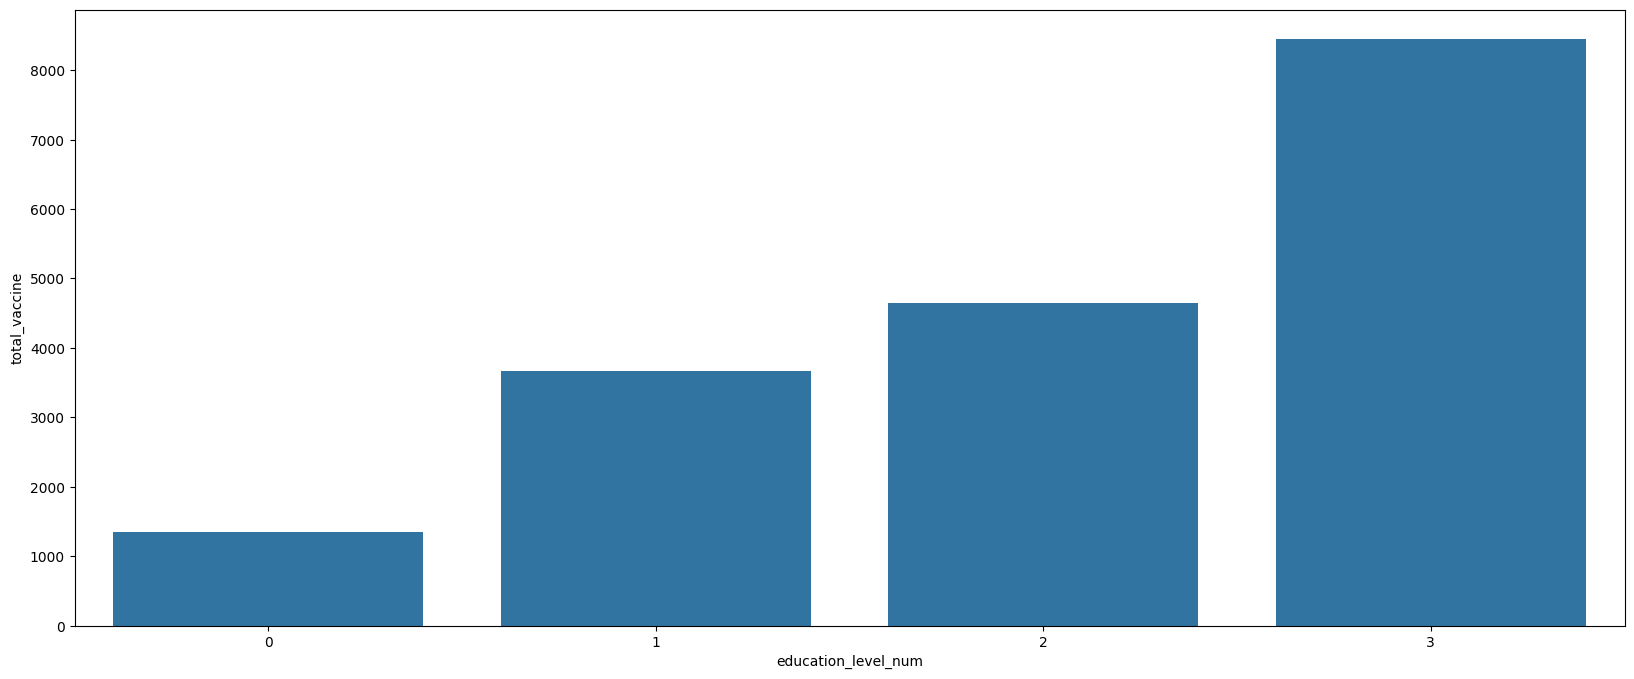

In [35]:
aux1 = ( df4[['education_level_num', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'education_level_num' )
                                                                         .sum()
                                                                         .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                            + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='education_level_num', y='total_vaccine', data=aux1);

**H3 - Pessoas casadas tendem a se vacinar mais.**

**VERDADEIRA** - Casados se vacinam mais 

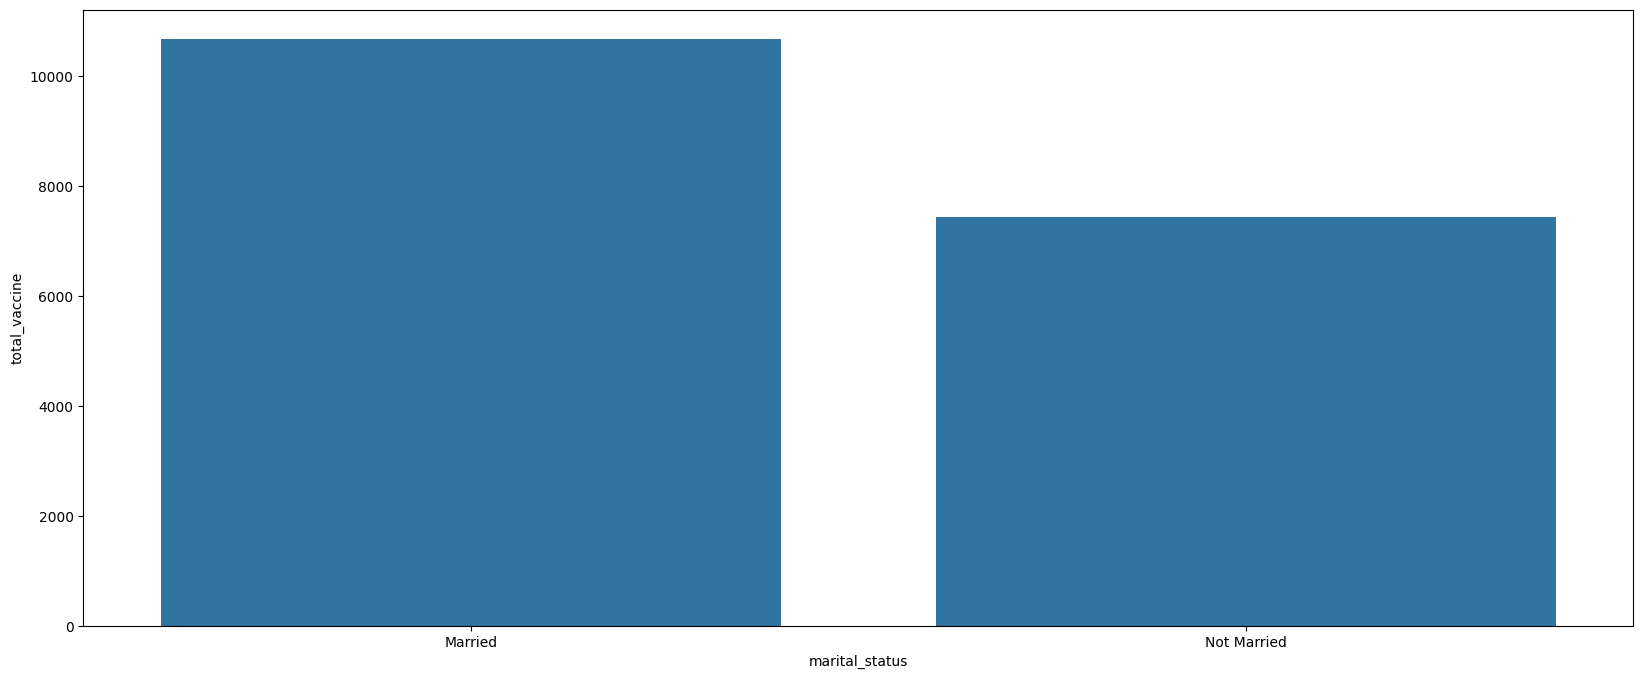

In [36]:
aux1 = (df4[['marital_status', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'marital_status' )
                                                                   .sum()
                                                                   .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                                  + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='marital_status', y='total_vaccine', data=aux1);

**H4 - Mulheres se vacinam mais do que homens.**

**VERDADEIRO**

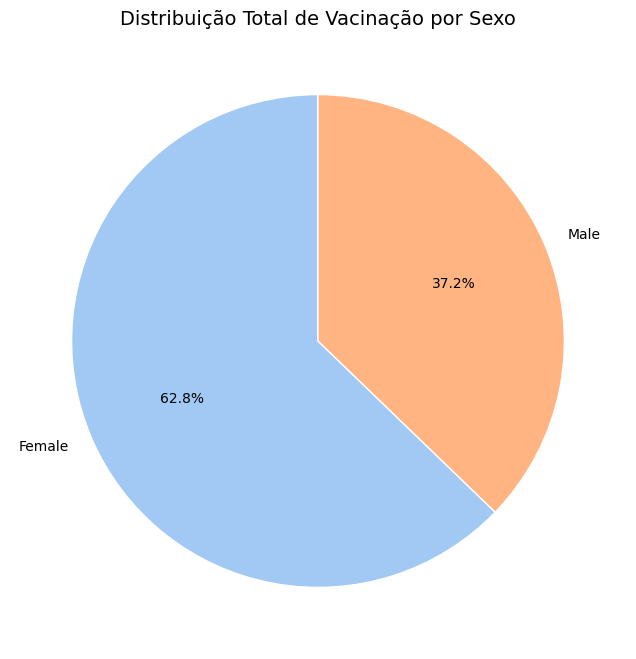

In [37]:
aux1 = ( df4[['sex', 'h1n1_vaccine', 'seasonal_vaccine']].groupby('sex', as_index=False)
                                                         .sum() )
aux1['total_vaccine'] = aux1['h1n1_vaccine'] + aux1['seasonal_vaccine']

# Criando o gráfico de pizza
colors = sns.color_palette('pastel')[0:len(aux1)]

plt.figure(figsize=(8, 8))
plt.pie(
    aux1['total_vaccine'],
    labels=aux1['sex'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Distribuição Total de Vacinação por Sexo', fontsize=14)
plt.show()


**H5 - Pacientes com renda mais alta se vacina mais do que pacientes com renda mais baixa.**

**FALSA**

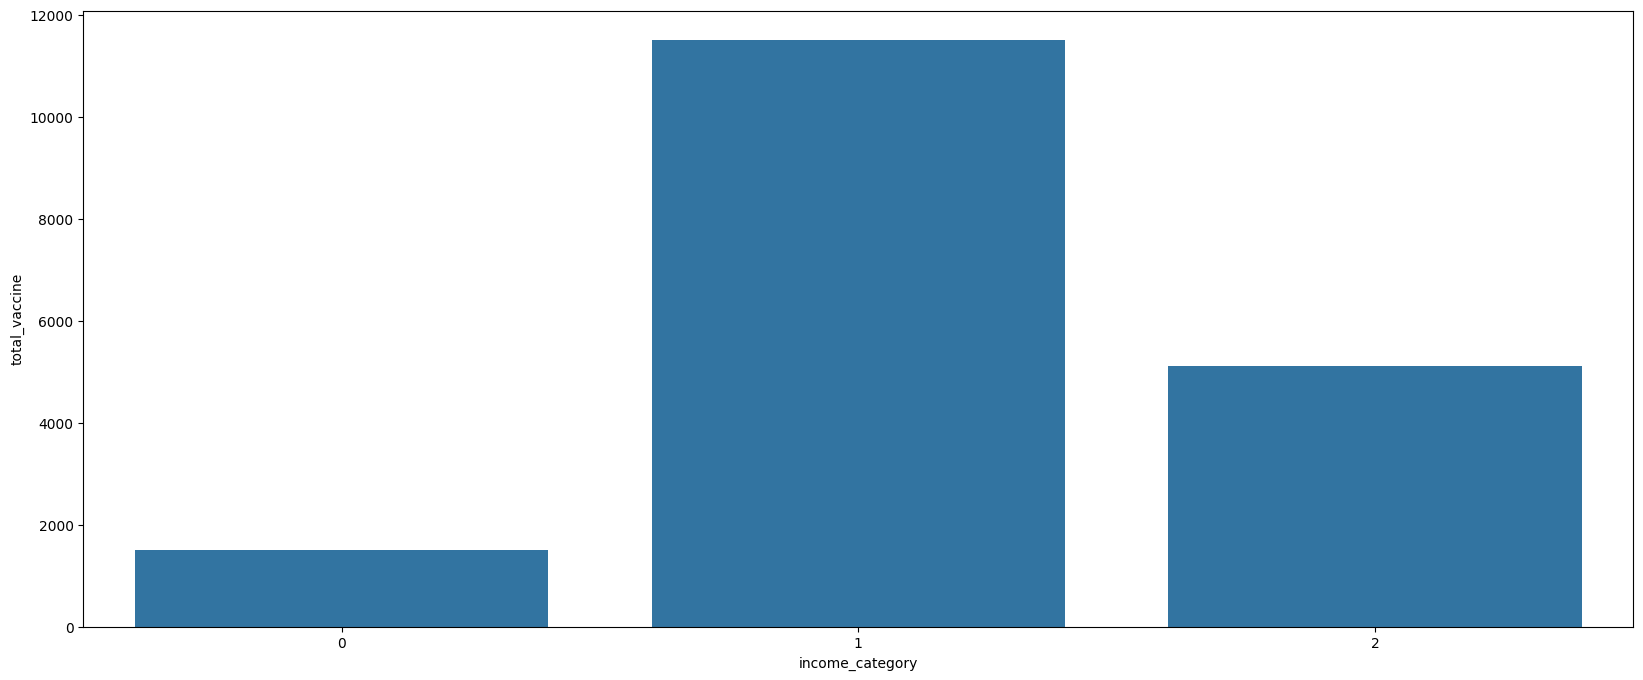

In [38]:
aux1 = (df4[['income_category', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'income_category' )
                                                                    .sum()
                                                                    .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                                   + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='income_category', y='total_vaccine', data=aux1);

**H6 - Pessoas não brancas apresentam menor taxa de vacinação.**

**VERDADEIRO**

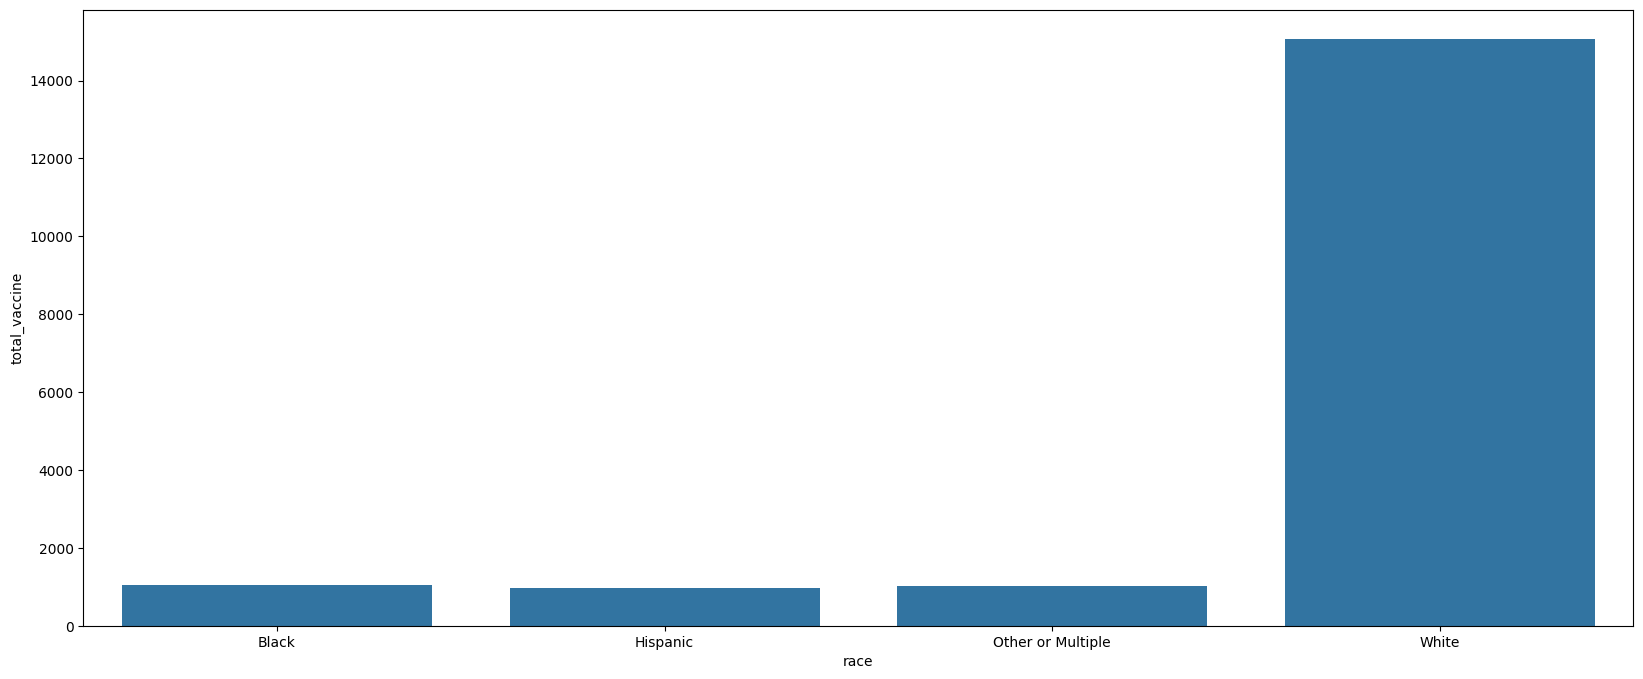

In [39]:
aux1 = (df4[['race', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'race' )
                                                         .sum()
                                                         .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                        + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='race', y='total_vaccine', data=aux1);

**H7 - Pacientes com filhos pequenos tem maior probabilidade de vacinação para proteger a família.**

**FALSO**

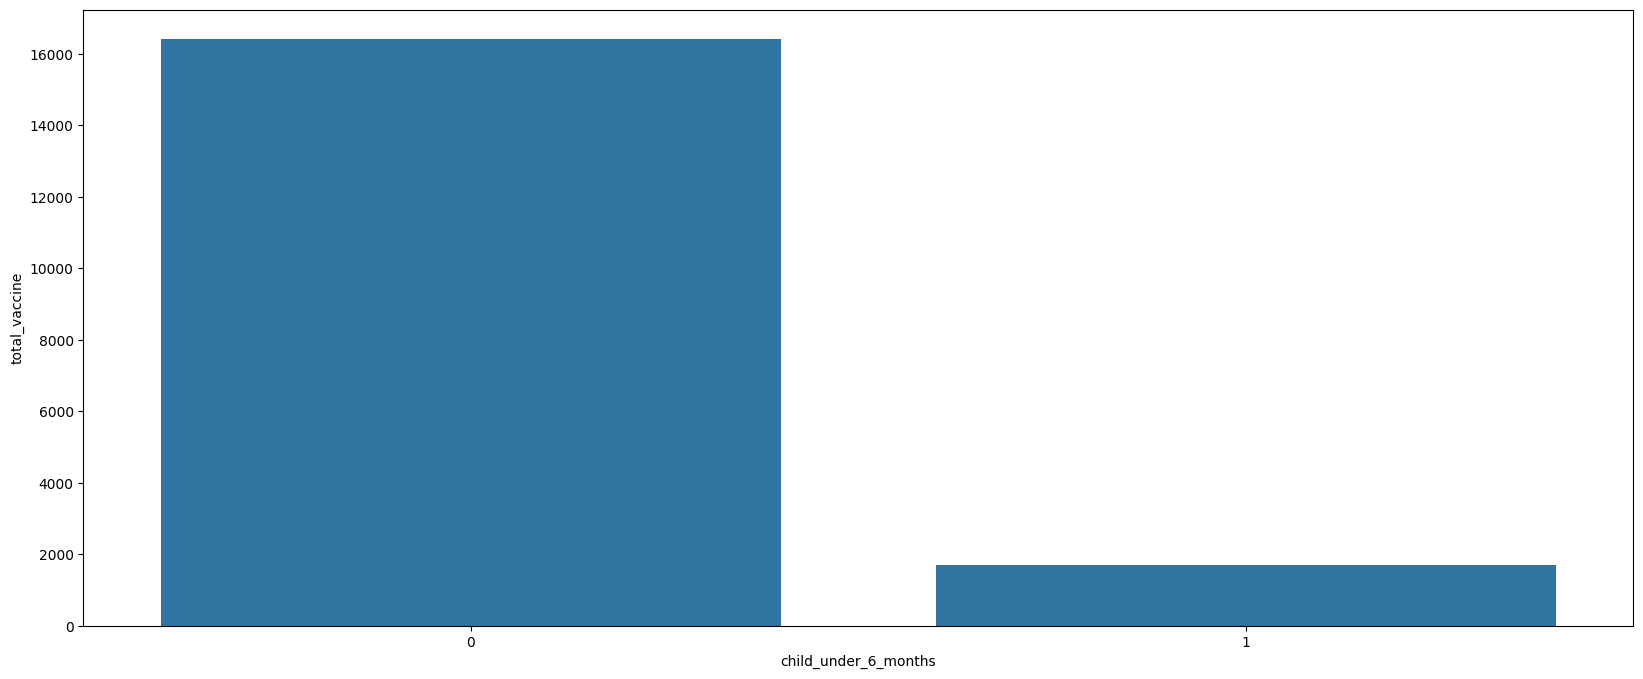

In [40]:
aux1 = (df4[['child_under_6_months', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'child_under_6_months' )
                                                                         .sum()
                                                                         .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                                        + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='child_under_6_months', y='total_vaccine', data=aux1);

**H8 - 1. Pessoas que percebem alto risco de contágio vacinam-se mais.**

**VERDADEIRO**

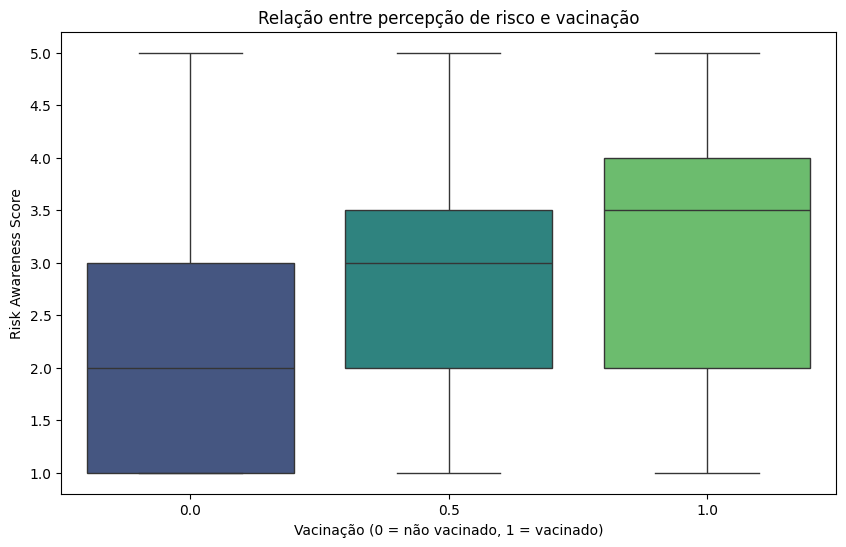

In [41]:
aux = (
    df4[['risk_awareness_score', 'h1n1_vaccine', 'seasonal_vaccine']]
    .assign(total_vaccine=lambda x: (x['h1n1_vaccine'] + x['seasonal_vaccine']) / 2)
)

plt.figure(figsize=(10,6))
sns.boxplot(data=aux, x='total_vaccine', y='risk_awareness_score', palette='viridis')
plt.title('Relação entre percepção de risco e vacinação')
plt.xlabel('Vacinação (0 = não vacinado, 1 = vacinado)')
plt.ylabel('Risk Awareness Score')
plt.show()


**H9 - Pessoas em grupos de risco (por condição crônica ou filhos pequenos) buscam mais a vacinação**

**FALSO**

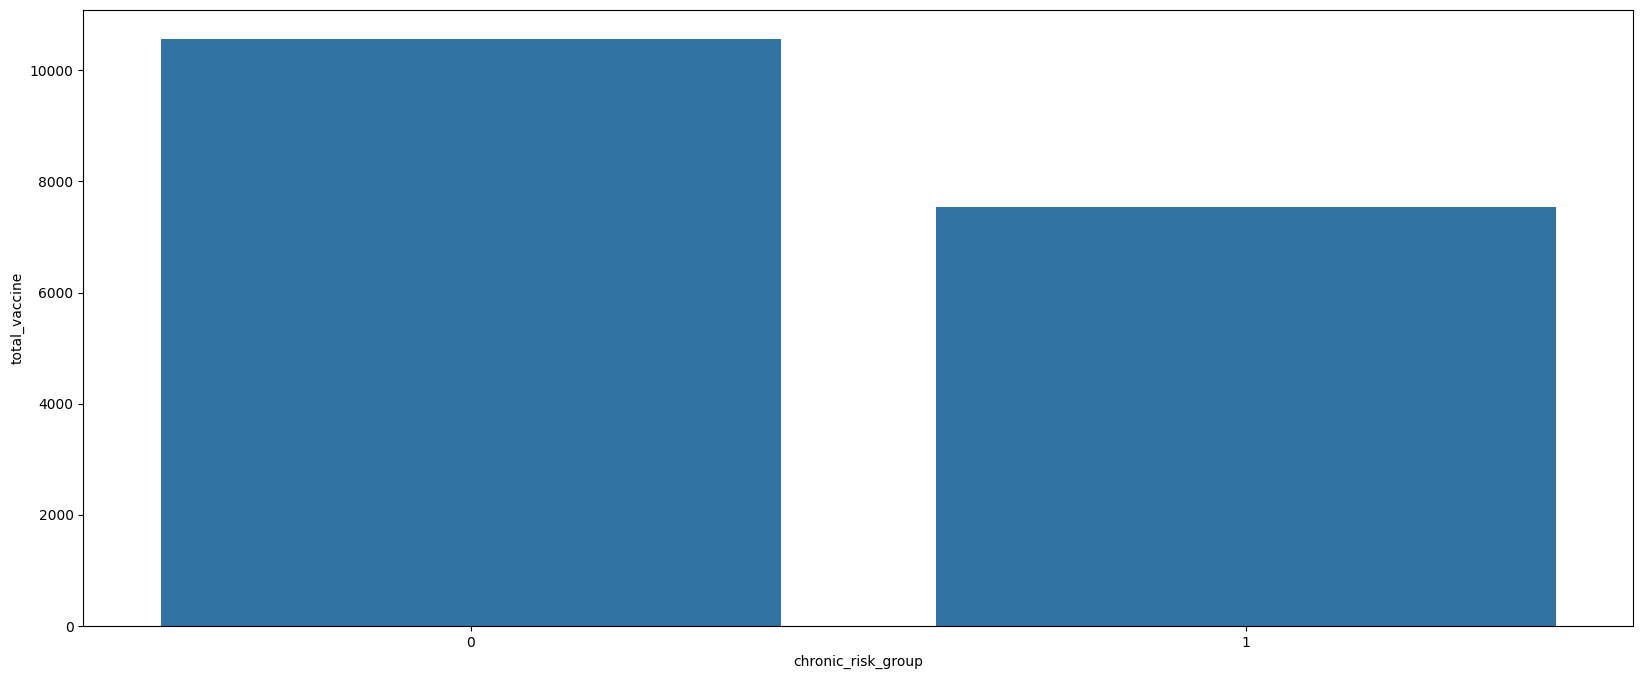

In [42]:
aux1 = (df4[['chronic_risk_group', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'chronic_risk_group' )
                                                                       .sum()
                                                                       .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                                      + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='chronic_risk_group', y='total_vaccine', data=aux1);

**H10 - Profissionais da área de saúde são mais vacinados por exigência profissional.**

**FALSO**

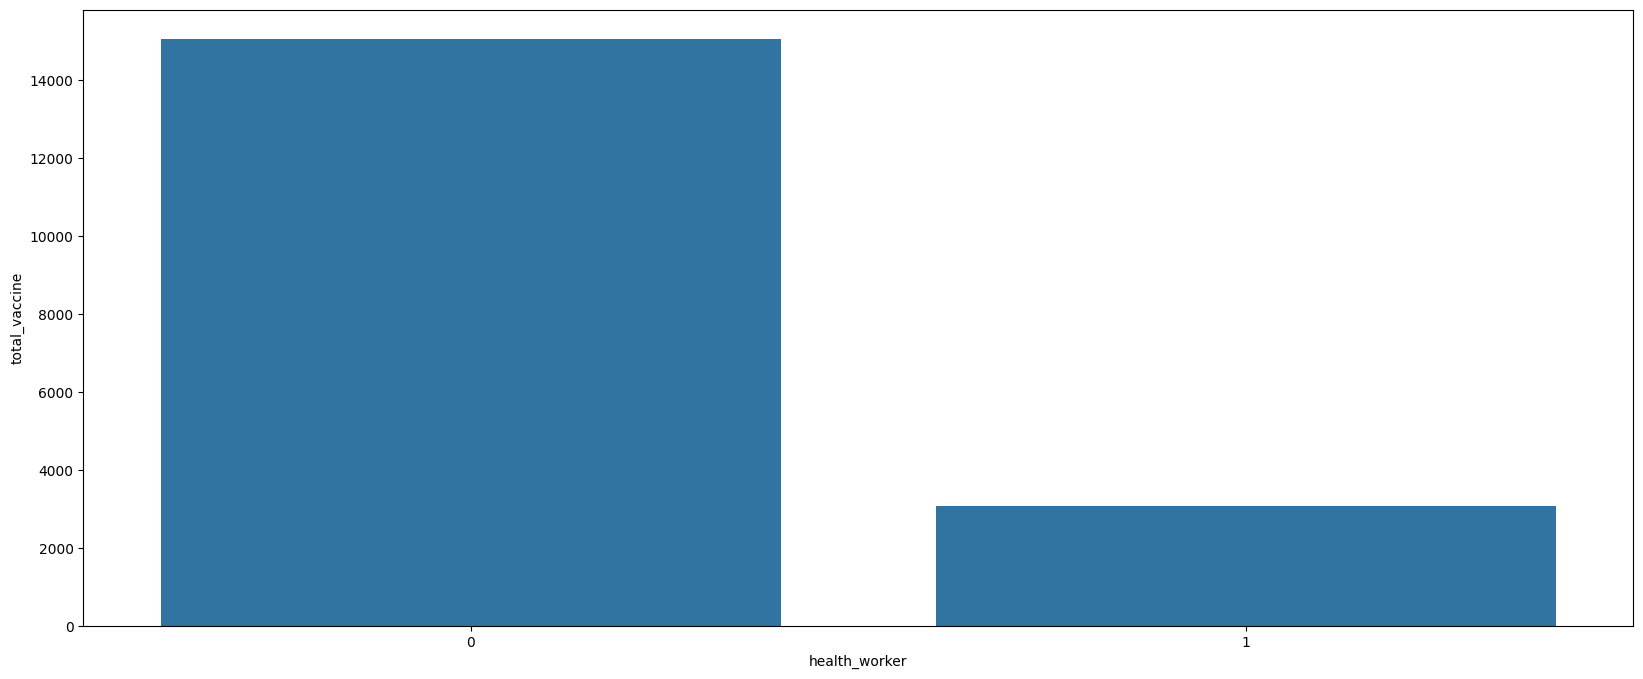

In [43]:
aux1 = (df4[['health_worker', 'h1n1_vaccine', 'seasonal_vaccine']].groupby( 'health_worker' )
                                                                   .sum()
                                                                   .assign( total_vaccine=lambda x: x['h1n1_vaccine']
                                                                                                      + x['seasonal_vaccine'] ))

plt.figure( figsize=(20,8))
sns.barplot( x='health_worker', y='total_vaccine', data=aux1);

## 4.3. Analise Multivariada

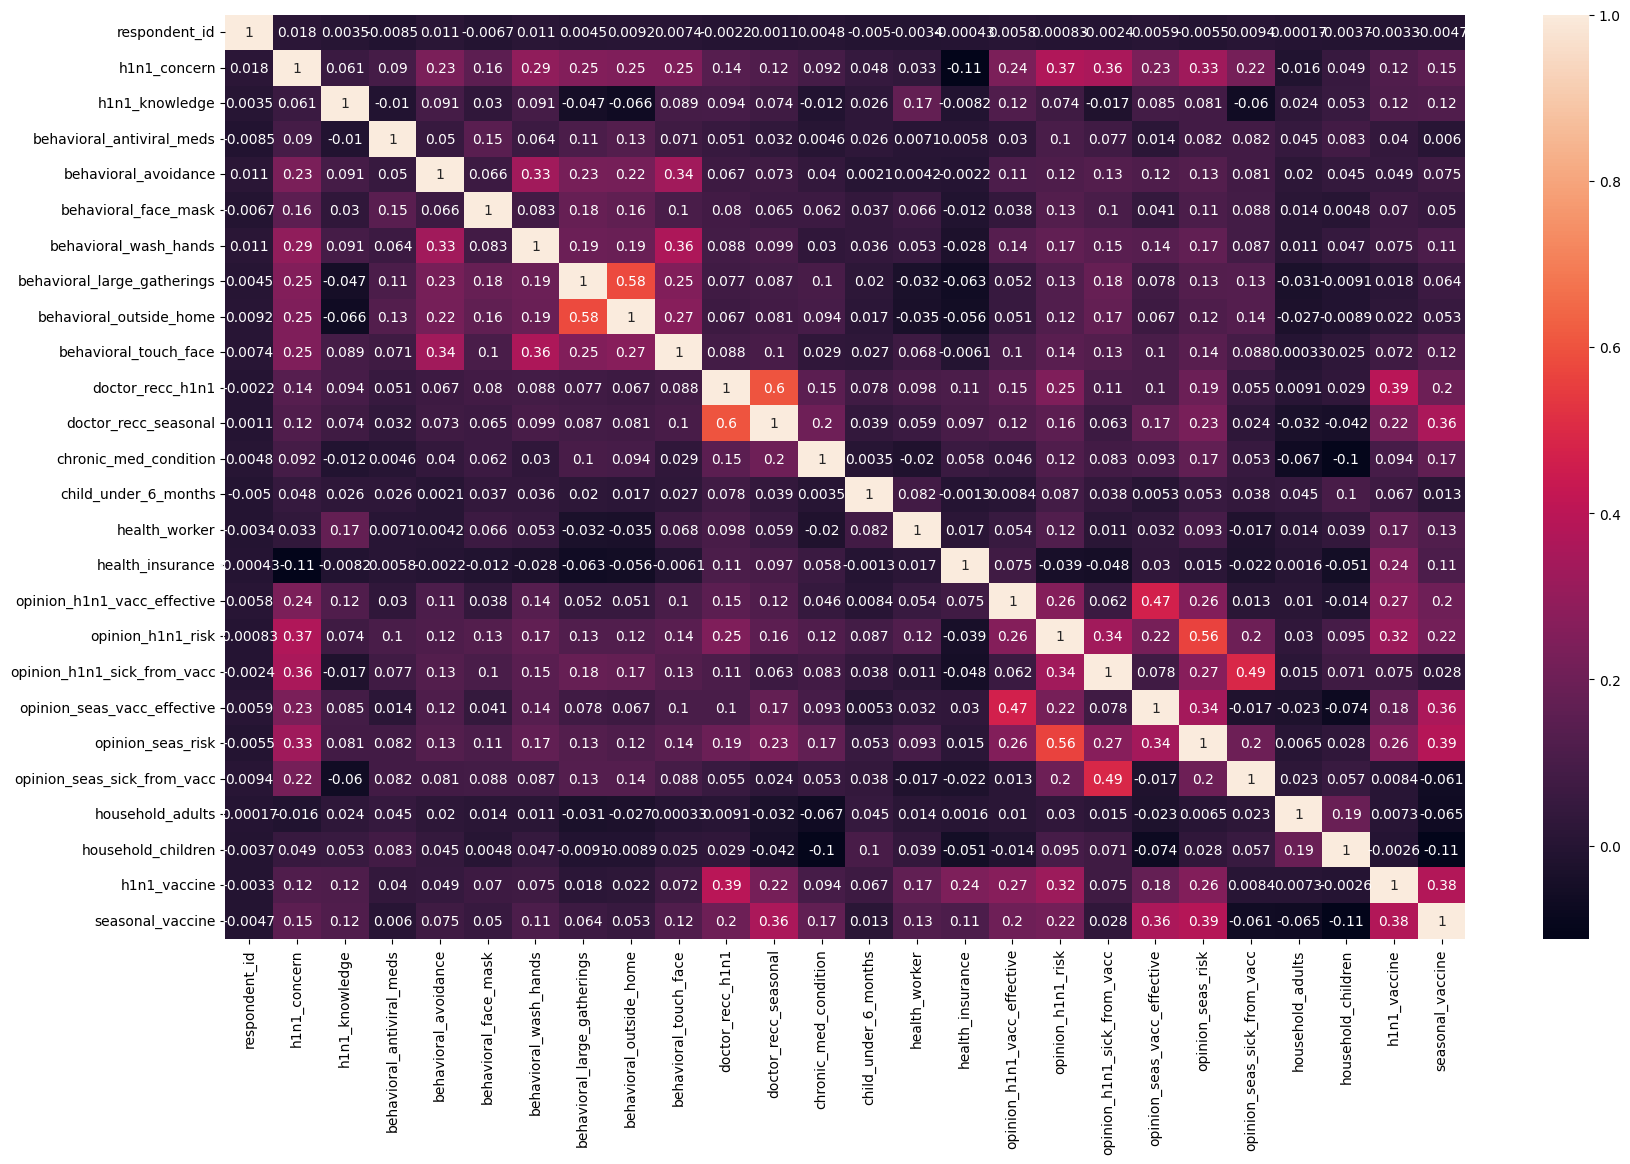

In [44]:
correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(20, 12))
sns.heatmap( correlation, annot=True);

# 5.0. PREPARAÇÃO DOS DADOS

In [45]:
df5 = df4.copy()

## 5.1. Normalização

In [46]:
scaler = StandardScaler()
df5['opinion_vacc_positive'] = scaler.fit_transform(df5[['opinion_vacc_positive']])

## 5.2. Rescaling

In [47]:
mm = MinMaxScaler()
df5[['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
     'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
     'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'health_behaviors_score',
     'risk_awareness_score', 'family_size', 'education_level_num', 'opinion_gap']] = mm.fit_transform(df5[['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                                                                                                           'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                                                                                                           'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'health_behaviors_score',
                                                                                                           'risk_awareness_score', 'family_size', 'education_level_num', 'opinion_gap']])

## 5.3. Transformação

### 5.3.1. Encoding

In [48]:
# age_group, race, sex, marital_status, rent_or_own - One Hot Encoding
df5 = pd.get_dummies( df5, columns=['age_group', 'race', 'sex', 'marital_status', 'rent_or_own'], drop_first=True)

In [49]:
df5.head()

h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0      0.333333             0.0                          0   
1      1.000000             1.0                          0   
2      0.333333             0.5                          0   
3      0.333333             0.5                          0   
4      0.666667             0.5                          0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                     0                     0                      0   
1                     1                     0                      1   
2                     1                     0                      0   
3                     1                     0                      1   
4                     1                     0                      1   

   behavioral_large_gatherings  behavioral_outside_home  \
0                            0                        1   
1                            0                        1   
2                            0                        0   
3                            1                        0   
4                            1                        0   

   behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                      1                 0                     0   
1                      1                 0                     0   
2                      0                 0                     0   
3                      0                 0                     1   
4                      1                 0                     0   

   chronic_med_condition  child_under_6_months  health_worker  \
0                      0                     0              0   
1                      0                     0              0   
2                      1                     0              0   
3                      1                     0              0   
4                      0                     0              0   

   health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
0                 1                          0.5               0.00   
1                 1                          1.0               0.75   
2                -1                          0.5               0.00   
3                -1                          0.5               0.50   
4                -1                          0.5               0.50   

   opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
0                         0.75                         0.25   
1                         0.25                         0.75   
2                         1.00                         0.75   
3                         0.00                         1.00   
4                         0.75                         0.50   

   opinion_seas_risk  opinion_seas_sick_from_vacc  household_adults  \
0               0.00                         0.75          0.000000   
1               0.25                         0.25          0.000000   
2               0.00                         0.75          0.666667   
3               0.75                         1.00          0.000000   
4               0.00                         0.25          0.333333   

   household_children  h1n1_vaccine  seasonal_vaccine  health_behaviors_score  \
0                 0.0             0                 0                0.285714   
1                 0.0             0                 1                0.571429   
2                 0.0             0                 0                0.142857   
3                 0.0             0                 1                0.428571   
4                 0.0             0                 0                0.571429   

   doctor_recc_any  opinion_vacc_positive  risk_awareness_score  has_children  \
0                0              -1.508603                 0.000             0   
1                0              -0.402009                 0.500             0   
2                0              -0.678658                 0.000             0  

# 6.0. FEATURE SELECTION

In [50]:
df6 = df5.copy()

## 6.1. Separação DataFrame

In [51]:
# targets
y_h1n1 = df6['h1n1_vaccine']
y_seasonal = df6['seasonal_vaccine']

# Features
X = df6.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

## 6.2. Select KBest

### 6.2.1. Select H1N1 X Seasonal

In [52]:
selector_h1n1 = SelectKBest(score_func=mutual_info_classif, k='all')
selector_h1n1.fit(X, y_h1n1)

selector_seasonal = SelectKBest(score_func=mutual_info_classif, k='all')
selector_seasonal.fit(X, y_seasonal)

# Montando DataFrame com scores
df_scores = pd.DataFrame({
    'feature': X.columns,
    'h1n1_score': selector_h1n1.scores_,
    'seasonal_score': selector_seasonal.scores_
})

# Normalizando os scores para %
df_scores['h1n1_importance_%'] = 100 * df_scores['h1n1_score'] / df_scores['h1n1_score'].sum()
df_scores['seasonal_importance_%'] = 100 * df_scores['seasonal_score'] / df_scores['seasonal_score'].sum()

# Ordenando por maior importância média
df_scores['avg_importance'] = (df_scores['h1n1_importance_%'] + df_scores['seasonal_importance_%']) / 2
df_scores = df_scores.sort_values('avg_importance', ascending=False).reset_index(drop=True)

# Exibe as top 15 features
df_scores.head(15)

feature  h1n1_score  seasonal_score  \
0         opinion_vacc_positive    0.054743        0.089365   
1          risk_awareness_score    0.056533        0.070812   
2             opinion_seas_risk    0.030700        0.078820   
3   opinion_seas_vacc_effective    0.019008        0.089667   
4              doctor_recc_h1n1    0.069609        0.018335   
5               doctor_recc_any    0.032789        0.057392   
6             has_health_access    0.044261        0.036448   
7             opinion_h1n1_risk    0.051541        0.024938   
8          doctor_recc_seasonal    0.020829        0.067912   
9   opinion_h1n1_vacc_effective    0.045047        0.024201   
10             health_insurance    0.033172        0.015827   
11          age_group_65+ Years    0.006453        0.032252   
12                  opinion_gap    0.014886        0.008451   
13        chronic_med_condition    0.006190        0.018905   
14           chronic_risk_group    0.006636        0.017043   

    h1n1_importance_%  seasonal_importance_%  avg_importance  
0            9.693518              11.230288       10.461903  
1           10.010367               8.898850        9.454609  
2            5.436081               9.905146        7.670614  
3            3.365800              11.268215        7.317008  
4           12.325745               2.304165        7.314955  
5            5.805990               7.212273        6.509132  
6            7.837375               4.580355        6.208865  
7            9.126451               3.133896        6.130173  
8            3.688294               8.534351        6.111323  
9            7.976581               3.041320        5.508950  
10           5.873822               1.988922        3.931372  
11           1.142702               4.053017        2.597859  
12           2.635873               1.062054        1.848963  
13           1.096018               2.375712        1.735865  
14           1.175136               2.141709        1.658422

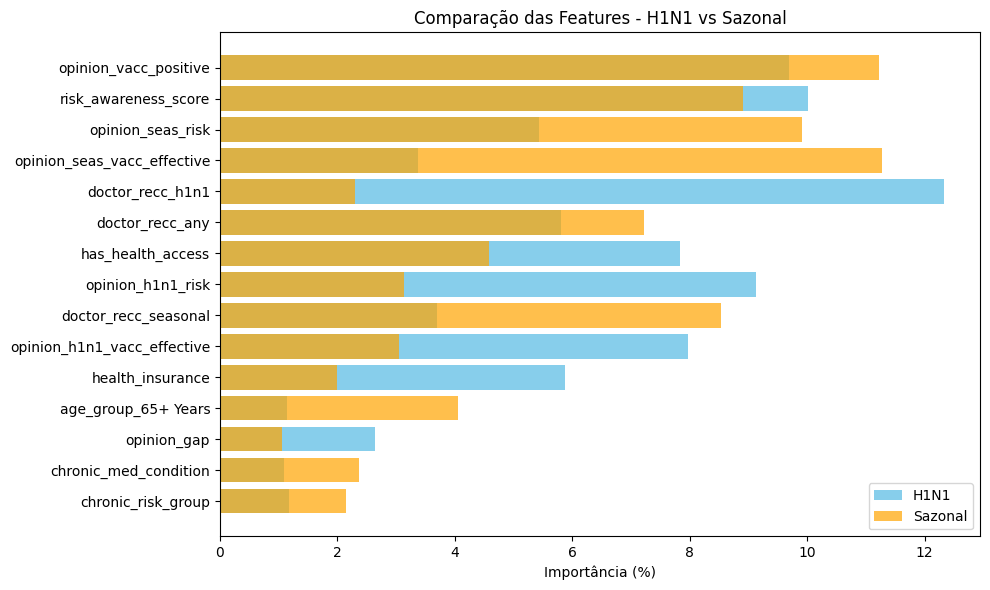

In [53]:
top_n = 15  # número de features para exibir

plt.figure(figsize=(10, 6))
plt.barh(
    df_scores['feature'][:top_n],
    df_scores['h1n1_importance_%'][:top_n],
    color='skyblue',
    label='H1N1'
)
plt.barh(
    df_scores['feature'][:top_n],
    df_scores['seasonal_importance_%'][:top_n],
    color='orange',
    alpha=0.7,
    label='Sazonal'
)
plt.gca().invert_yaxis()  # inverter eixo Y para mostrar as mais importantes no topo
plt.xlabel('Importância (%)')
plt.title('Comparação das Features - H1N1 vs Sazonal')
plt.legend()
plt.tight_layout()
plt.show()


### 6.2.2. Top Features por vacina

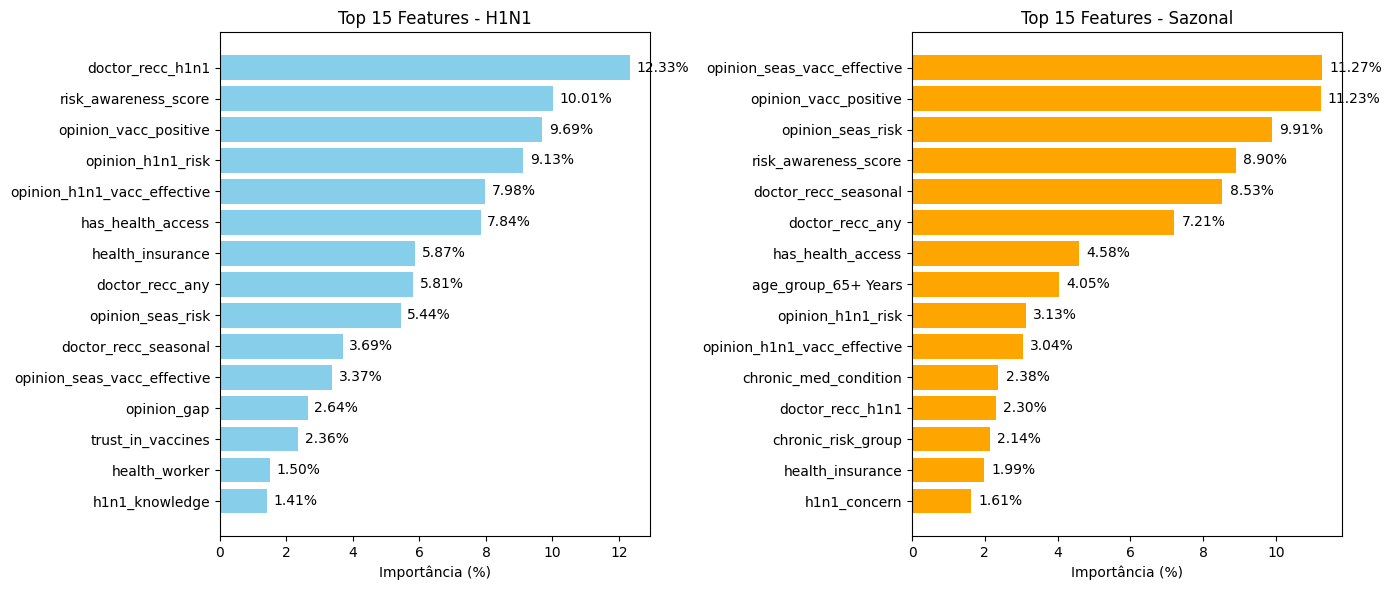

In [54]:
# Top 15 H1N1
top_h1n1 = df_scores.sort_values('h1n1_importance_%', ascending=False).head(15)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(top_h1n1['feature'], top_h1n1['h1n1_importance_%'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Features - H1N1')
plt.xlabel('Importância (%)')

# Adiciona rótulos de percentual
for i, v in enumerate(top_h1n1['h1n1_importance_%']):
    plt.text(v + 0.2, i, f'{v:.2f}%', va='center')

# Top 15 Sazonal
top_seasonal = df_scores.sort_values('seasonal_importance_%', ascending=False).head(15)

plt.subplot(1, 2, 2)
plt.barh(top_seasonal['feature'], top_seasonal['seasonal_importance_%'], color='orange')
plt.gca().invert_yaxis()
plt.title('Top 15 Features - Sazonal')
plt.xlabel('Importância (%)')

# Adiciona rótulos de percentual
for i, v in enumerate(top_seasonal['seasonal_importance_%']):
    plt.text(v + 0.2, i, f'{v:.2f}%', va='center')

plt.tight_layout()
plt.show()


## 6.3. Feature Selection

### 6.3.1. Feature H1N1

In [56]:
cols_selected_h1n1 = top_h1n1['feature'].tolist()
X_h1n1 = df6[cols_selected_h1n1]

### 6.3.2. Feature Seasonal

In [57]:
cols_selected_seasonal = top_seasonal['feature'].tolist()
X_seasonal = df6[cols_selected_seasonal]

# 7.0 Machine Learning Modelling

In [59]:
# Modelo h1n1
Xh_train, Xh_valid, yh_train, yh_valid = train_test_split(
    X_h1n1,
    y_h1n1,
    test_size=0.2,
    random_state=42,
    stratify=y_h1n1
)

# Modelo Sazonal
Xs_train, Xs_valid, ys_train, ys_valid = train_test_split(
    X_seasonal,
    y_seasonal,
    test_size=0.2,
    random_state=42,
    stratify=y_seasonal
)

In [62]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:, 1]

    return {
        'Accuracy': accuracy_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds),
        'AUC ROC': roc_auc_score(y_test, preds_proba)
    }

## 7.1. H1N1

In [ ]:
# ---------------------------
# 1️⃣ Logistic Regression
# ---------------------------
logreg_h1n1 = LogisticRegression(max_iter=500)
results_logreg_h1n1 = evaluate_model(logreg_h1n1, Xh_train, Xh_valid, yh_train, yh_valid)

# ---------------------------
# 2️⃣ Random Forest
# ---------------------------
rf_h1n1 = RandomForestClassifier(n_estimators=400, random_state=42)
results_rf_h1n1 = evaluate_model(rf_h1n1, Xh_train, Xh_valid, yh_train, yh_valid)

# ---------------------------
# 3️⃣ LightGBM
# ---------------------------
lgbm_h1n1 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

results_lgbm_h1n1 = evaluate_model(lgbm_h1n1, Xh_train, Xh_valid, yh_train, yh_valid)

# Mostrar resultados
results_df_h = pd.DataFrame([
    {"Modelo": "Logistic Regression", **results_logreg_h1n1},
    {"Modelo": "Random Forest", **results_rf_h1n1},
    {"Modelo": "LightGBM", **results_lgbm_h1n1},
])

results_df_h


[LightGBM] [Info] Number of positive: 4539, number of negative: 16826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212450 -> initscore=-1.310219
[LightGBM] [Info] Start training from score -1.310219
Resultados H1N1:
Logistic Regression: {'Accuracy': 0.8470610258330213, 'F1 Score': 0.5693199789140748, 'AUC ROC': 0.8443317148155634}
Random Forest: {'Accuracy': 0.8251591164357919, 'F1 Score': 0.5362462760675273, 'AUC ROC': 0.7989454328793317}
LightGBM: {'Accuracy': 0.8406963684013478, 'F1 Score': 0.5678009141696293, 'AUC ROC': 0.8418399583660126}


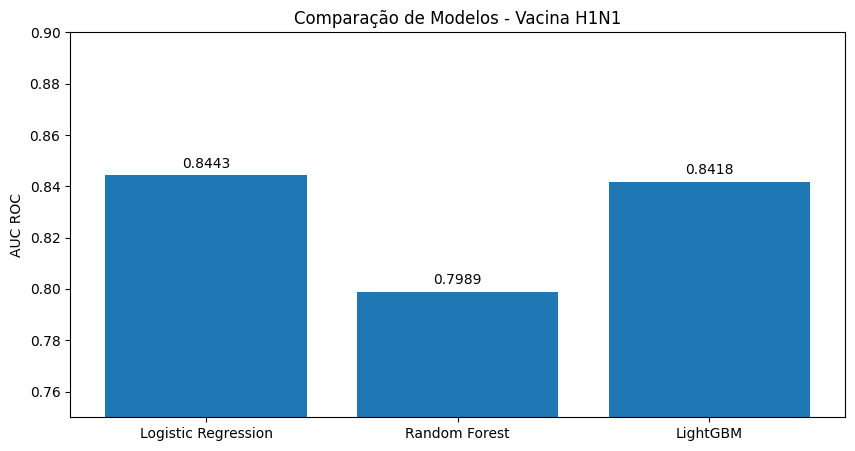

In [65]:
models = ["Logistic Regression", "Random Forest", "LightGBM"]
auc_scores = [
    results_logreg_h1n1["AUC ROC"],
    results_rf_h1n1["AUC ROC"],
    results_lgbm_h1n1["AUC ROC"],
]

plt.figure(figsize=(10,5))
plt.bar(models, auc_scores)
plt.ylabel("AUC ROC")
plt.title("Comparação de Modelos - Vacina H1N1")
plt.ylim(0.75, 0.90)

# adicionar valores no topo das barras
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.003, f"{v:.4f}", ha="center")

plt.show()


## 7.2. Treino Vacina Sazonal

In [ ]:
# ---------------------------
# 1️⃣ Logistic Regression
# ---------------------------
logreg_seas = LogisticRegression(max_iter=500)
results_logreg_seas = evaluate_model(logreg_seas, Xs_train, Xs_valid, ys_train, ys_valid)

# ---------------------------
# 2️⃣ Random Forest
# ---------------------------

rf_seas = RandomForestClassifier(n_estimators=400, random_state=42)
results_rf_seas = evaluate_model(rf_seas, Xs_train, Xs_valid, ys_train, ys_valid)

# ---------------------------
# 3️⃣ LightGBM
# ---------------------------

lgbm_seas = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

results_lgbm_seas = evaluate_model(lgbm_seas, Xs_train, Xs_valid, ys_train, ys_valid)

# Mostrar resultados
results_df_s = pd.DataFrame([
    {"Modelo": "Logistic Regression", **results_logreg_seas},
    {"Modelo": "Random Forest", **results_rf_seas},
    {"Modelo": "LightGBM", **results_lgbm_seas},
])

results_df_s


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9948, number of negative: 11417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 21365, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465621 -> initscore=-0.137732
[LightGBM] [Info] Start training from score -0.137732


Modelo  Accuracy  F1 Score   AUC ROC
0  Logistic Regression  0.756645  0.729392  0.840520
1        Random Forest  0.736428  0.711594  0.799863
2             LightGBM  0.760202  0.737554  0.842574

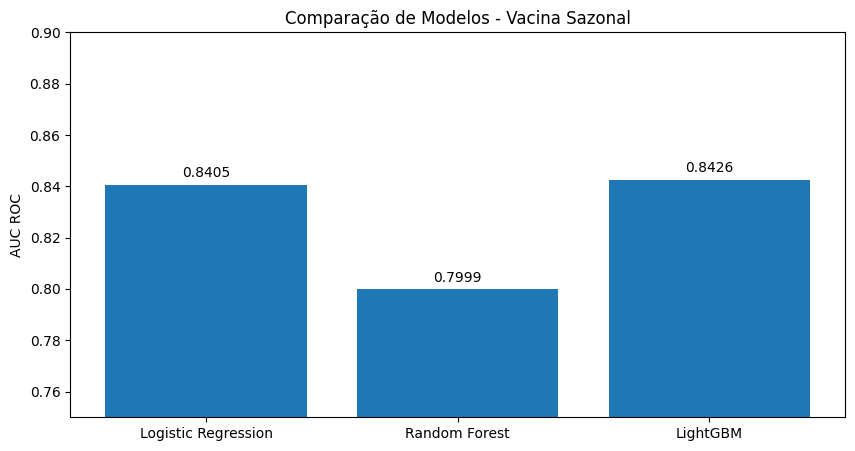

In [67]:
models = ["Logistic Regression", "Random Forest", "LightGBM"]
auc_scores = [
    results_logreg_seas["AUC ROC"],
    results_rf_seas["AUC ROC"],
    results_lgbm_seas["AUC ROC"],
]

plt.figure(figsize=(10,5))
plt.bar(models, auc_scores)
plt.ylabel("AUC ROC")
plt.title("Comparação de Modelos - Vacina Sazonal")
plt.ylim(0.75, 0.90)

# adicionar valores no topo das barras
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.003, f"{v:.4f}", ha="center")

plt.show()


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. RandomizedSearchCV - H1N1

In [ ]:
# Espaço de Busca
#param_grid = {
#    "num_leaves": [15, 31, 63, 127],
#    "max_depth": [-1, 5, 10, 15],
#    "learning_rate": [0.01, 0.03, 0.05, 0.1],
#    "n_estimators": [200, 400, 600, 800],
#    "subsample": [0.7, 0.8, 0.9, 1.0],
#    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
#    "reg_alpha": [0.0, 0.1, 0.3, 0.5],
#    "reg_lambda": [0.0, 0.1, 0.3, 0.5]
#}

# RandomizedSearchCV
#lgbm = LGBMClassifier(random_state=42)

#random_search = RandomizedSearchCV(
#    estimator=lgbm,
#    param_distributions=param_grid,
#    n_iter=40,               # pode aumentar para mais qualidade
#    scoring="roc_auc",
#    cv=5,                    # 5-fold cross validation
#    verbose=1,
#    n_jobs=-1,               # usa todos os núcleos
#    random_state=42
#)

#random_search.fit(Xh_train, yh_train)

#print("Melhores hiperparâmetros:", random_search.best_params_)
#print("Melhor AUC ROC:", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3631, number of negative: 13461
[LightGBM] [Info] Number of positive: 3632, number of negative: 13460
[LightGBM] [Info] Number of positive: 3632, number of negative: 13460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 17092, number of used features: 15
[LightGBM] [Info] [binary:B

## 8.2. RandomizedSearchCV - Sazonal

In [ ]:
# Espaço de Busca
#param_grid = {
#    "num_leaves": [15, 31, 63, 127],
#    "max_depth": [-1, 5, 10, 15],
#    "learning_rate": [0.01, 0.03, 0.05, 0.1],
#    "n_estimators": [200, 400, 600, 800],
#    "subsample": [0.7, 0.8, 0.9, 1.0],
#    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
#    "reg_alpha": [0.0, 0.1, 0.3, 0.5],
#    "reg_lambda": [0.0, 0.1, 0.3, 0.5]
#}

# RandomizedSearchCV
#lgbm = LGBMClassifier(random_state=42)

#random_search = RandomizedSearchCV(
#    estimator=lgbm,
#    param_distributions=param_grid,
#    n_iter=40,               # pode aumentar para mais qualidade
#    scoring="roc_auc",
#    cv=5,                    # 5-fold cross validation
#    verbose=1,
#    n_jobs=-1,               # usa todos os núcleos
#    random_state=42
#)

#random_search.fit(Xs_train, ys_train)

#print("Melhores hiperparâmetros:", random_search.best_params_)
#print("Melhor AUC ROC:", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7959, number of negative: 9133
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7959, number of negative: 9133
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7958, number of negative: 9134
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7958, number of negative: 9134
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7959, number of negative: 9133
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7958, number of negative: 9134
[LightGBM] [Info] Auto-choosing row-wise mul

## 8.3. Final Model

In [71]:
param_tuned = {'subsample': 0.8, 
               'reg_lambda': 0.0, 
               'reg_alpha': 0.0, 
               'num_leaves': 15, 
               'n_estimators': 800, 
               'max_depth': -1, 
               'learning_rate': 0.01, 
               'colsample_bytree': 0.7}